In [20]:
import os
import sys
import glob
import numpy as np
from obspy import read_inventory, UTCDateTime
from pprint import pprint

localLibPath = os.path.join('..', 'lib')
sys.path.append(localLibPath)
from libseisGT import detect_network_event
from seisan_classes import set_globals, read_seisandb_apply_custom_function_to_each_event
#import libSeisan2Pandas as seisan
#import libMVO 
from SAM import DSAM
from ASL import ASL, initial_source, make_grid
from InventoryTools import show_response #, has_response
from obspy import Stream


#SDS_DIR = '/data/SDS' #'/Volumes/NTFS_2TB_EXT/SDS'
HOME = os.path.expanduser('~')
if sys.platform == "darwin":
    print("Running on macOS")
    if os.path.exists('/Volumes/DATA'):
        SEISAN_DATA = os.path.join('/Volumes/DATA/SEISAN_DB')
    else:
        raise Exception('No SEISAN_DB found: did you forget to mount the DATA drive?')
elif sys.platform.startswith("linux"):
    print("Running on Linux")
    SEISAN_DATA = '/data/SEISAN_DB'
#DATA_DIR = os.path.join(HOME, 'Dropbox/BRIEFCASE/MESS2024/skience2024_GTplus/02 Volcano Monitoring/data')
#SAM_DIR = os.path.join(DATA_DIR,'continuous','SAM')
#SAM_DIR = '/data/SAM' #os.path.join(DATA_DIR,'continuous','SAM')
#DEM_DIR = os.path.join(DATA_DIR,'DEMs')
#RESPONSE_DIR = os.path.join(DATA_DIR,'responses')
#SEISAN_DATA = os.path.join( '/data', 'SEISAN_DB')
#DB = 'MVOE_'

SEISAN_DATA, DB, station_locationsDF, inv = set_globals(SEISAN_DATA=SEISAN_DATA)
print(inv)
show_response(inv)

startdate=UTCDateTime(2001,3,1,14,16,0)
enddate=UTCDateTime(2001,3,2)
import numpy as np
import matplotlib.pyplot as plt

def plot_amplitude_spectra(stream):
    plt.figure(figsize=(10, 6))

    for tr in stream:
        # Get time sampling interval (dt) and number of samples (N)
        dt = tr.stats.delta  # Time step
        N = len(tr.data)  # Number of samples

        # Compute FFT
        fft_vals = np.fft.fft(tr.data)
        freqs = np.fft.fftfreq(N, d=dt)  # Frequency axis

        # Compute amplitude spectrum (absolute value of FFT)
        amplitude_spectrum = np.abs(fft_vals)

        # Plot only positive frequencies (since FFT is symmetric)
        positive_freqs = freqs[:N//2]
        positive_amplitudes = amplitude_spectrum[:N//2]

        plt.plot(positive_freqs, positive_amplitudes, label=tr.id)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude Spectrum of Seismic Signals")
    plt.legend()
    plt.grid()
    plt.xlim(0, 50)  # Adjust frequency range as needed
    plt.show()


import numpy as np
import matplotlib.pyplot as plt

def plot_amplitude_ratios(signal_stream, noise_stream, log_scale=False, smooth_window=None):
    plt.figure(figsize=(10, 6))

    # Create a dictionary for noise traces for quick lookup
    noise_dict = {tr.id: tr for tr in noise_stream}

    spectral_ratios_list = []
    freqs_list = []

    for sig_tr in signal_stream:
        trace_id = sig_tr.id
        if trace_id not in noise_dict:
            print(f"Skipping {trace_id}: No matching noise trace.")
            continue

        noise_tr = noise_dict[trace_id]

        # Ensure both traces have the same length
        min_len = min(len(sig_tr.data), len(noise_tr.data))
        sig_data = sig_tr.data[:min_len]
        noise_data = noise_tr.data[:min_len]

        # Get sampling interval (dt) and number of samples (N)
        dt = sig_tr.stats.delta
        N = min_len  # Use the shortest available length

        # Compute FFT for signal and noise
        fft_signal = np.fft.fft(sig_data)
        fft_noise = np.fft.fft(noise_data)
        freqs = np.fft.fftfreq(N, d=dt)  # Frequency axis

        # Compute amplitude spectrum
        amp_signal = np.abs(fft_signal)
        amp_noise = np.abs(fft_noise)

        # Avoid division by zero by replacing zeros with a small number
        amp_noise[amp_noise == 0] = 1e-10  

        # Compute amplitude ratio
        amplitude_ratio = amp_signal / amp_noise

        # Smooth the amplitude ratio using a moving average if requested
        if smooth_window:
            kernel = np.ones(smooth_window) / smooth_window
            amplitude_ratio = np.convolve(amplitude_ratio, kernel, mode="same")

        # Store spectral ratios for computing the overall ratio
        spectral_ratios_list.append(amplitude_ratio[:N//2])
        freqs_list.append(freqs[:N//2])

        # Plot only positive frequencies for individual traces
        if log_scale:
            plt.plot(freqs[:N//2], np.log10(amplitude_ratio[:N//2] + 1), label=trace_id, alpha=0.5, linewidth=1)
        else:
            plt.plot(freqs[:N//2], amplitude_ratio[:N//2], label=trace_id, alpha=0.5, linewidth=1)

    # Compute the overall spectral ratio by summing all individual ratios
    if spectral_ratios_list:
        avg_spectral_ratio = np.mean(np.array(spectral_ratios_list), axis=0)  # Compute the mean spectral ratio
        avg_freqs = freqs_list[0]  # All traces should have the same frequency bins

        # Plot the overall spectral ratio with a thicker line
        if log_scale:
            plt.plot(avg_freqs, np.log10(avg_spectral_ratio + 1), color="black", linewidth=3, label="Overall Ratio")
        else:
            plt.plot(avg_freqs, avg_spectral_ratio, color="black", linewidth=3, label="Overall Ratio")

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude Ratio (Signal/Noise)")
    plt.title("Amplitude Ratio of Signal to Noise")
    plt.legend()
    plt.grid()
    plt.xlim(0, 50)  # Adjust frequency range as needed
    plt.ylim(bottom=0)  # Ensure no negative values
    plt.show()


Running on macOS
Inventory created at 2024-01-11T03:20:26.394930Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (54):
			MV (54x)
		Stations (75):
			MV.MBBE () (3x)
			MV.MBBY () (6x)
			MV.MBFL () (3x)
			MV.MBFR () (3x)
			MV.MBGA () (3x)
			MV.MBGB () (6x)
			MV.MBGE () (3x)
			MV.MBGH () (9x)
			MV.MBHA () (3x)
			MV.MBLG () (6x)
			MV.MBLY () (6x)
			MV.MBMH () (3x)
			MV.MBRV () (3x)
			MV.MBRY () (9x)
			MV.MBSS () (3x)
			MV.MBWH () (6x)
		Channels (75):
			MV.MBBE..BHZ, MV.MBBE..BHN, MV.MBBE..BHE, MV.MBBY..BHZ, 
			MV.MBBY..BHN, MV.MBBY..BHE, MV.MBBY..HHZ, MV.MBBY..HHN, 
			MV.MBBY..HHE, MV.MBFL..EHZ, MV.MBFL..EHN, MV.MBFL..EHE, 
			MV.MBFR..HHZ, MV.MBFR..HHN, MV.MBFR..HHE, MV.MBGA..BHZ, 
			MV.MBGA..BHN, MV.MBGA..BHE, MV.MBGB..BHZ, MV.MBGB..BHN, 
			MV.MBGB..BHE, MV.MBGB..HHZ, MV.MBGB..HHN, MV.MBGB..HHE, 
			MV.MBGE..BHZ, MV.MBGE..BHN, MV.MBGE..BHE, MV.MBGH..BHZ, 
			MV.MBGH..BHN, MV.MBGH

REA path = /Volumes/DATA/SEISAN_DB/REA/MVOE_
years = [2001]
month = 3
['/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1417-27L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1421-48L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1424-35L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1433-45L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1437-22L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1444-33L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1446-52L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1456-16L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1500-02L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1505-15L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1508-04L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1513-58L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1519-29L.S200103', '/Volumes/DATA/SEISAN_DB/REA/MVOE_/2001/03/01-1522-10L.S200103', '/Volumes/DATA/SEIS

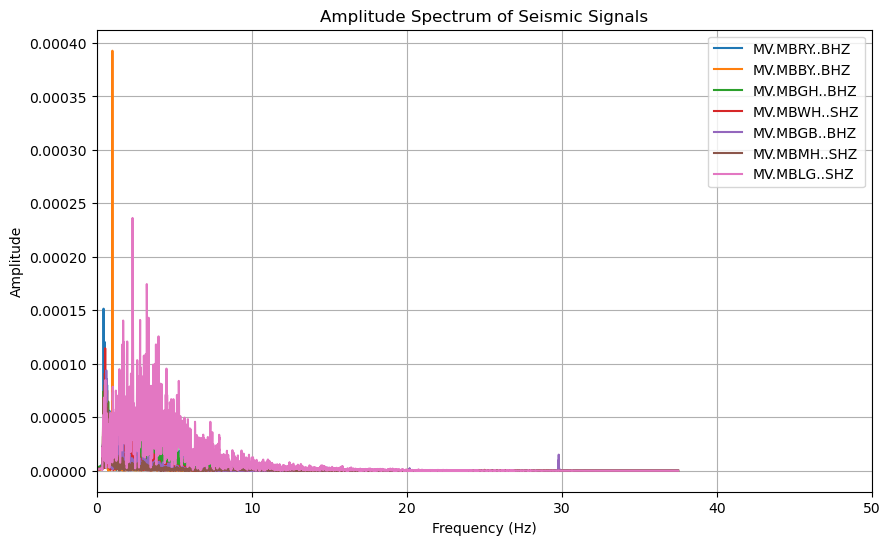

{'cft_peak_wmean': 6.237824683416322,
 'cft_peaks': [7.121938376838646,
               9.782499463218503,
               5.491465149675737,
               5.444152043978248,
               4.120498579793939,
               5.4663944869928605],
 'cft_std_wmean': 1.0765990233472034,
 'cft_stds': [1.1443526815899752,
              1.6033554835145083,
              0.9059403858059917,
              1.0635002584492361,
              0.7458916105309822,
              0.9965537201925267],
 'coincidence_sum': 6.0,
 'duration': 59.12000000476837,
 'similarity': {},
 'stations': ['MBRY', 'MBLG', 'MBGH', 'MBGB', 'MBWH', 'MBMH'],
 'time': UTCDateTime(2001, 3, 1, 14, 17, 37, 160000),
 'trace_ids': ['MV.MBRY..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBGH..BHZ',
               'MV.MBGB..BHZ',
               'MV.MBWH..SHZ',
               'MV.MBMH..SHZ']}


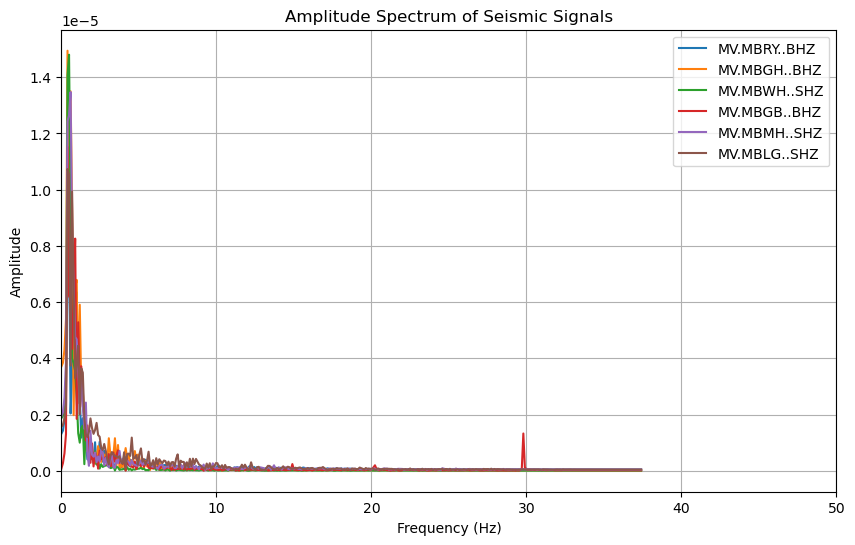

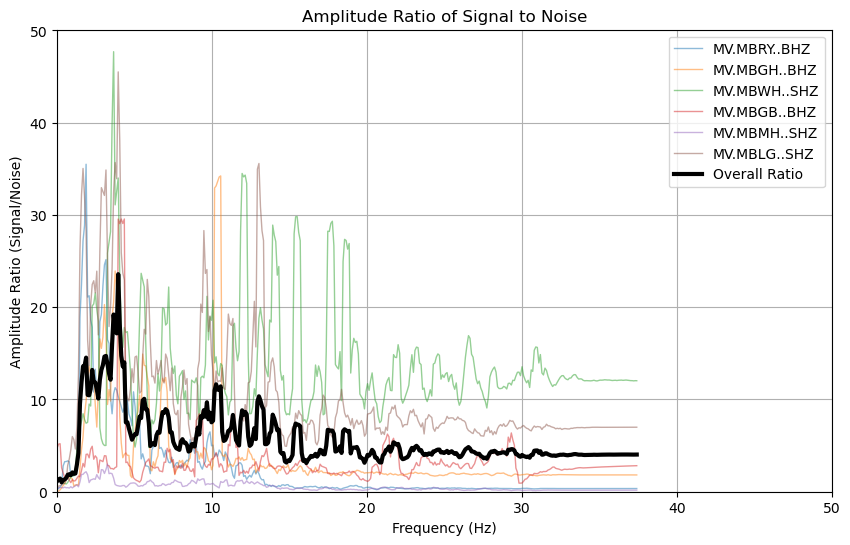

METRIC:  rms
3.37777721742371e-09
5.646801489519948e-09
2.1214368009044896e-09
4.147669085152635e-09
5.533618330069946e-09
5.734437263052146e-09
5.435253302628601e-09
8.125811552331589e-09
3.9465447907431866e-09
6.848672122867427e-09
6.013329958606166e-09
8.034339319609512e-09
1.1738538464109465e-09
1.4926193272080269e-09
4.5055956183278325e-10
1.0830964332123995e-09
1.0516647496418274e-09
2.793838673674708e-09
-62.26887174804517 -62.101807011107084 16.64190185927095 16.801901859270945
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1417-27L.S200103; WAVfile: None

Sfile: 01-1500-02L.S200103; WAVfile: 2001-03-01-1500-02S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T15:00:02.040000Z - 2001-03-01T15:01:43.026667Z | 75.0 Hz, 7575 samples
MV.MBSS..SHZ | 2001-03-01T15:00:02.040000Z - 2001-03-01T15:01:43.026667Z | 75.0 Hz, 7575 samples
MV.MBBY..BHZ | 2001-03-01T15:00:02.040000Z - 2001-03-01T15:01:43.026667Z | 75.0 Hz, 7575 samples
MV.MBGH..BHZ | 20

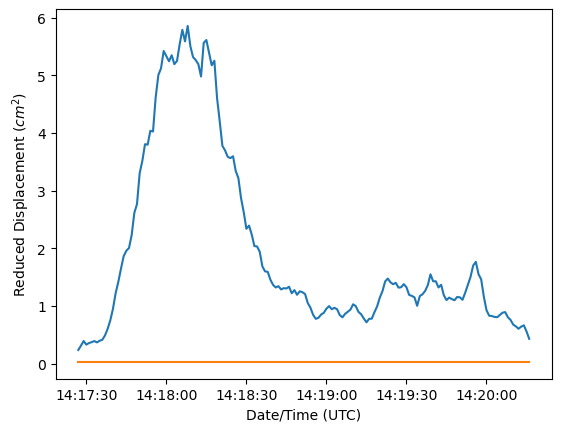

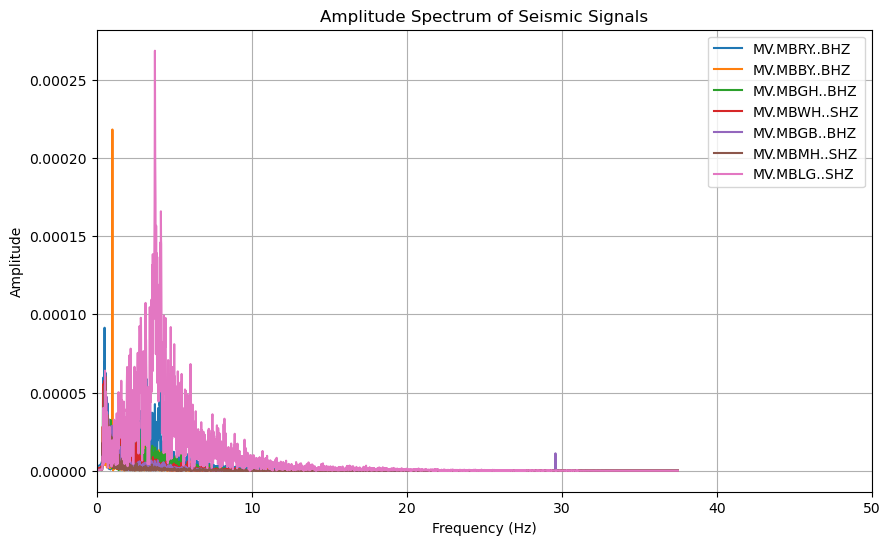

{'cft_peak_wmean': 5.976622294509403,
 'cft_peaks': [7.502731475419689,
               5.886741627010973,
               9.977135612582934,
               4.639578772504697,
               4.214717183044011,
               3.6388290964941135],
 'cft_std_wmean': 1.202187174171266,
 'cft_stds': [1.457344824753419,
              0.8932703955226888,
              2.154653577415393,
              1.0798758314007293,
              0.8246278685335312,
              0.8033505474018338],
 'coincidence_sum': 6.0,
 'duration': 61.34666669368744,
 'similarity': {},
 'stations': ['MBRY', 'MBGH', 'MBLG', 'MBWH', 'MBGB', 'MBMH'],
 'time': UTCDateTime(2001, 3, 1, 15, 0, 12, 40000),
 'trace_ids': ['MV.MBRY..BHZ',
               'MV.MBGH..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBWH..SHZ',
               'MV.MBGB..BHZ',
               'MV.MBMH..SHZ']}


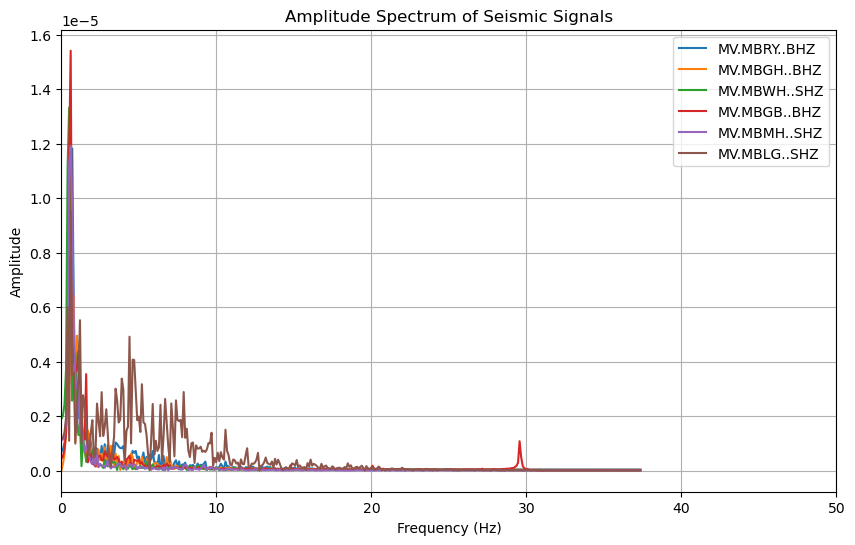

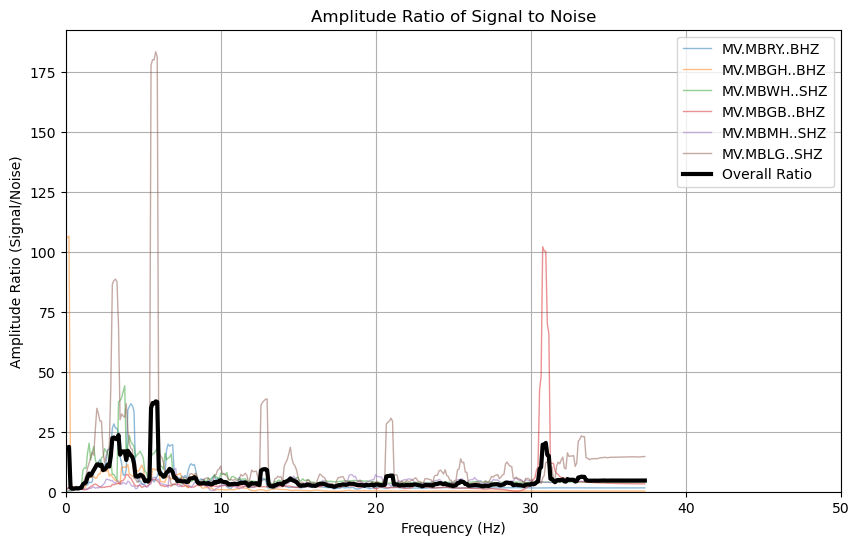

METRIC:  rms
8.532940496793322e-09
5.0280144350612075e-09
4.631871972923013e-09
3.856935799830702e-09
3.5838055494887686e-09
1.0465472692915694e-08
1.3225689745433271e-08
8.083168886463058e-09
6.006808742159395e-09
6.56041593314807e-09
6.532467150349238e-09
1.6177456497859933e-08
2.6029054551277487e-09
1.7998882735026386e-09
5.44354690261062e-10
1.1577161851896643e-09
8.309648262359735e-10
8.499867767198516e-09
-62.26684072154393 -62.099778347820305 16.639203894453196 16.799203894453193
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1500-02L.S200103; WAVfile: None

Sfile: 01-1513-58L.S200103; WAVfile: 2001-03-01-1513-58S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T15:13:58.040000Z - 2001-03-01T15:17:43.026667Z | 75.0 Hz, 16875 samples
MV.MBSS..SHZ | 2001-03-01T15:13:58.040000Z - 2001-03-01T15:17:43.026667Z | 75.0 Hz, 16875 samples
MV.MBBY..BHZ | 2001-03-01T15:13:58.040000Z - 2001-03-01T15:17:43.026667Z | 75.0 Hz, 16875 samples
MV.MBGH..BHZ 

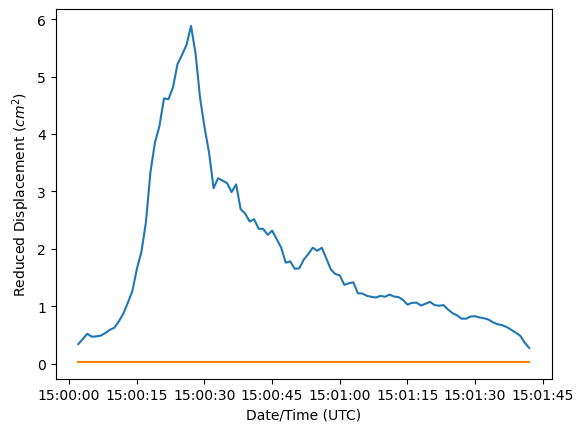

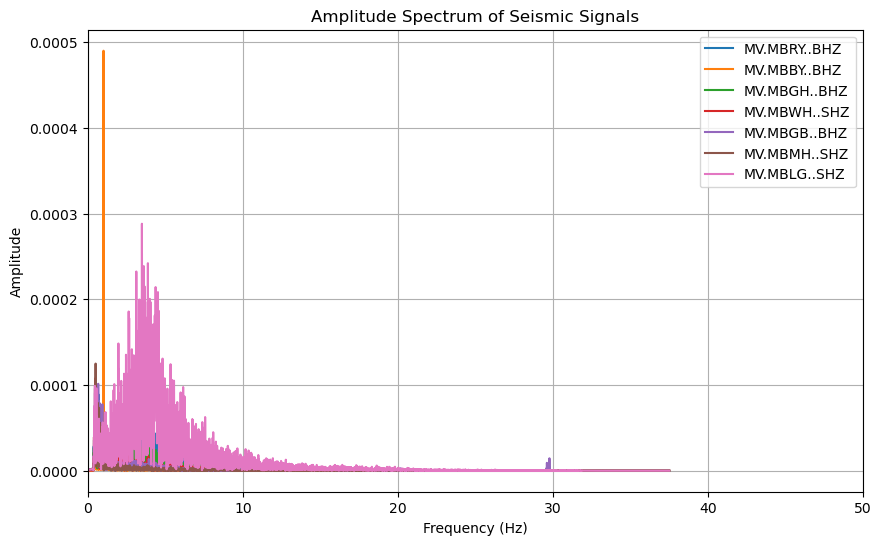

{'cft_peak_wmean': 4.858888687080232,
 'cft_peaks': [5.030417338887417,
               5.120209516689169,
               4.866360112694877,
               4.418567780049465],
 'cft_std_wmean': 0.9359902600235271,
 'cft_stds': [1.165424816798852,
              1.10572137340467,
              0.7669252810513116,
              0.7058895688392749],
 'coincidence_sum': 4.0,
 'duration': 78.36000001430511,
 'similarity': {},
 'stations': ['MBMH', 'MBGB', 'MBWH', 'MBRY'],
 'time': UTCDateTime(2001, 3, 1, 15, 14, 8, 40000),
 'trace_ids': ['MV.MBMH..SHZ', 'MV.MBGB..BHZ', 'MV.MBWH..SHZ', 'MV.MBRY..BHZ']}
Sfile: 01-1513-58L.S200103; WAVfile: None

Sfile: 01-1522-44L.S200103; WAVfile: 2001-03-01-1522-44S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T15:22:44.040000Z - 2001-03-01T15:24:25.026667Z | 75.0 Hz, 7575 samples
MV.MBSS..SHZ | 2001-03-01T15:22:44.040000Z - 2001-03-01T15:24:25.026667Z | 75.0 Hz, 7575 samples
MV.MBBY..BHZ | 2001-03-01T15:22:44.040000Z - 2001-03-01T15:24:25.026667

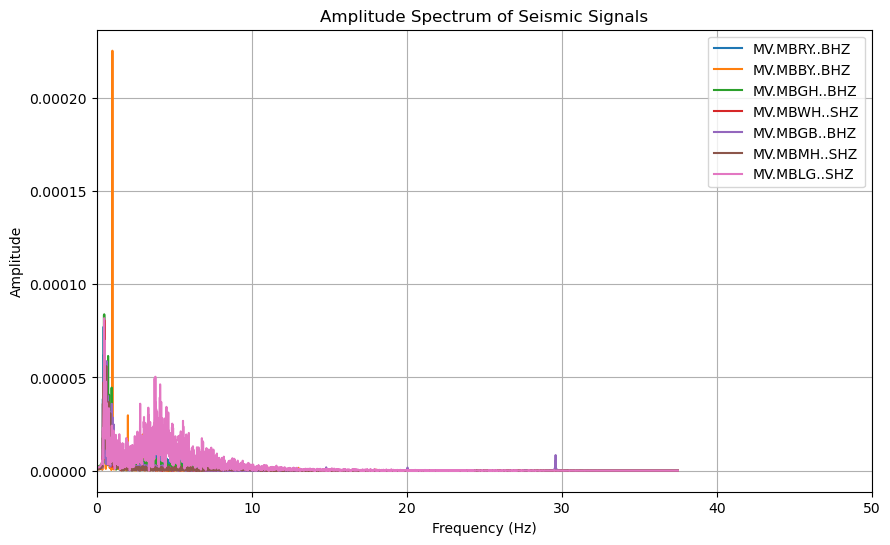

{'cft_peak_wmean': 4.182008025998604,
 'cft_peaks': [4.3028897248992255,
               3.817307642046705,
               4.757074426099471,
               3.7594316996463566,
               4.273336637301259],
 'cft_std_wmean': 0.8781241126306316,
 'cft_stds': [1.083928370382588,
              0.9508028086543009,
              0.7671630519390953,
              0.935636885922522,
              0.653089446254652],
 'coincidence_sum': 5.0,
 'duration': 29.56000006198883,
 'similarity': {},
 'stations': ['MBGB', 'MBMH', 'MBGH', 'MBWH', 'MBLG'],
 'time': UTCDateTime(2001, 3, 1, 15, 22, 56, 213333),
 'trace_ids': ['MV.MBGB..BHZ',
               'MV.MBMH..SHZ',
               'MV.MBGH..BHZ',
               'MV.MBWH..SHZ',
               'MV.MBLG..SHZ']}


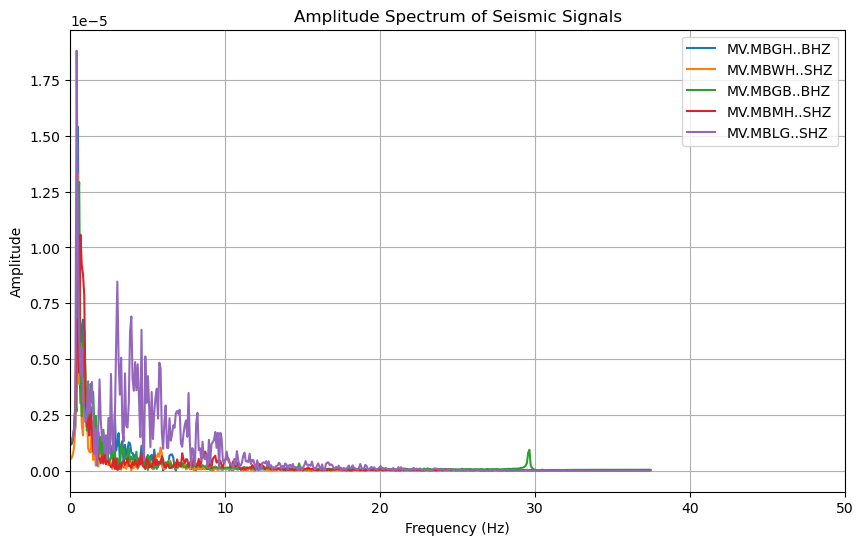

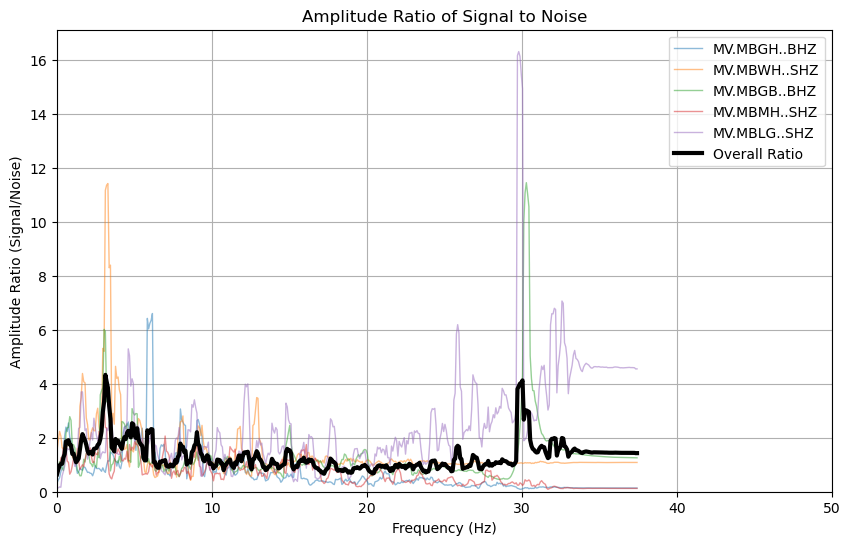

METRIC:  rms
5.243906884699265e-09
3.9192699356901644e-09
4.966653867455293e-09
4.2991856502432546e-09
1.1285366482357428e-08
6.045115920515827e-09
6.2587022987724104e-09
8.418285381560685e-09
6.191533897466456e-09
2.0121108350269157e-08
2.0222713126837264e-09
6.523010450013286e-10
9.015644456712929e-10
1.291740850183728e-09
9.134134685069483e-09
-62.266851363881756 -62.09976770548248 16.663485577812967 16.823485577812963
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1522-44L.S200103; WAVfile: None

Sfile: 01-1538-06L.S200103; WAVfile: 2001-03-01-1538-06S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T15:38:06.040000Z - 2001-03-01T15:39:02.026667Z | 75.0 Hz, 4200 samples
MV.MBSS..SHZ | 2001-03-01T15:38:06.040000Z - 2001-03-01T15:39:02.026667Z | 75.0 Hz, 4200 samples
MV.MBBY..BHZ | 2001-03-01T15:38:06.040000Z - 2001-03-01T15:39:02.026667Z | 75.0 Hz, 4200 samples
MV.MBGH..BHZ | 2001-03-01T15:38:06.040000Z - 2001-03-01T15:39:02.026667Z | 75.0 Hz

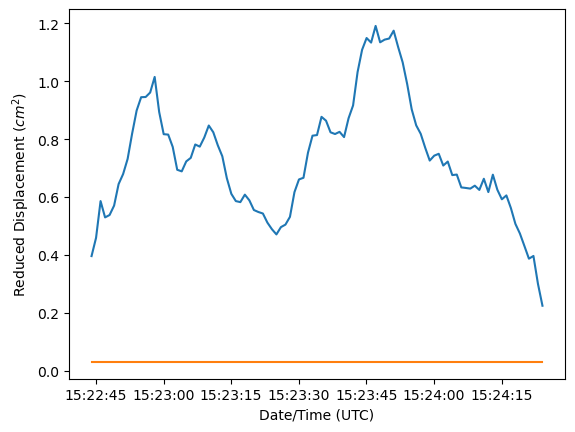

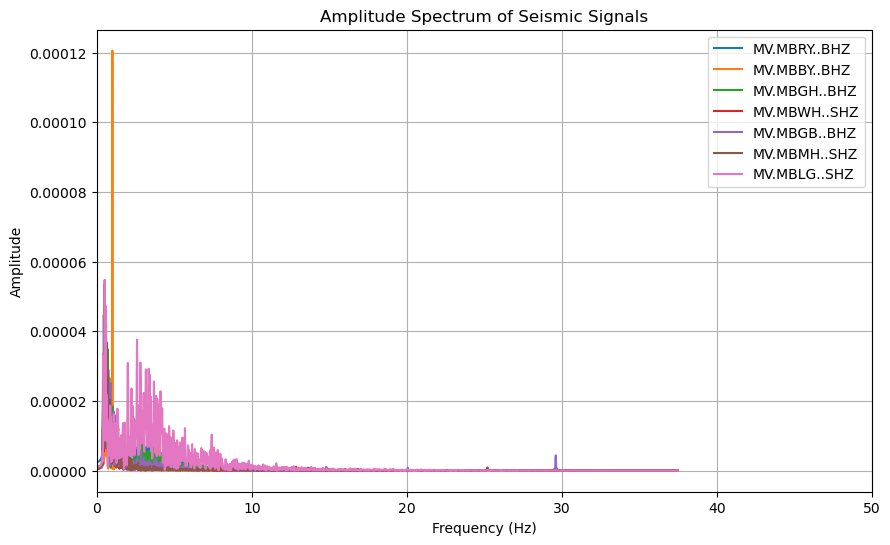

{'cft_peak_wmean': 4.628764992947155,
 'cft_peaks': [4.523481983691999,
               4.872253219172868,
               4.926177112227567,
               4.193147656696188],
 'cft_std_wmean': 1.1303482039192552,
 'cft_stds': [1.4223219848342246,
              1.3894510572152088,
              0.9612529478070058,
              0.7483668258205818],
 'coincidence_sum': 4.0,
 'duration': 30.62666666507721,
 'similarity': {},
 'stations': ['MBWH', 'MBMH', 'MBGB', 'MBGH'],
 'time': UTCDateTime(2001, 3, 1, 15, 38, 18, 253333),
 'trace_ids': ['MV.MBWH..SHZ', 'MV.MBMH..SHZ', 'MV.MBGB..BHZ', 'MV.MBGH..BHZ']}
Sfile: 01-1538-06L.S200103; WAVfile: None

Sfile: 01-1539-08L.S200103; WAVfile: 2001-03-01-1539-08S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T15:39:08.040000Z - 2001-03-01T15:39:46.026667Z | 75.0 Hz, 2850 samples
MV.MBSS..SHZ | 2001-03-01T15:39:08.040000Z - 2001-03-01T15:39:46.026667Z | 75.0 Hz, 2850 samples
MV.MBBY..BHZ | 2001-03-01T15:39:08.040000Z - 2001-03-01T15:39:46.0

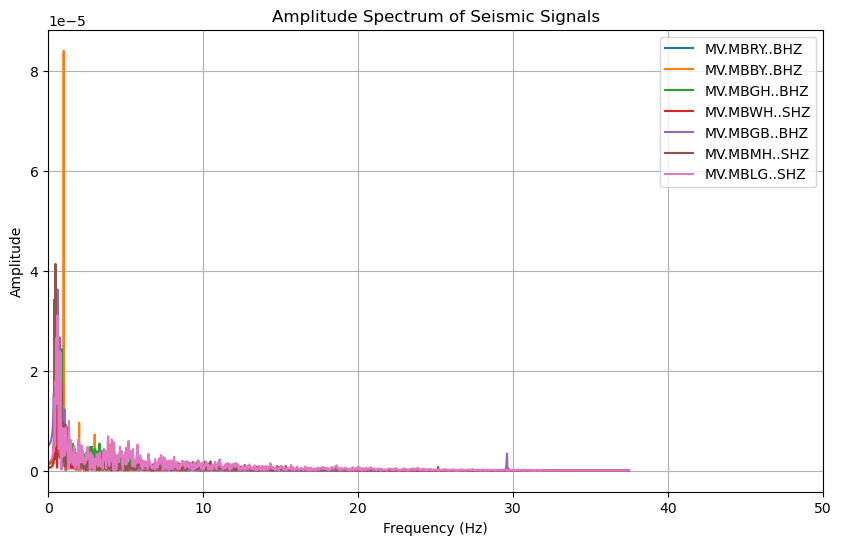

{'cft_peak_wmean': 4.694791481952286,
 'cft_peaks': [5.555833347889507,
               4.304626353314631,
               4.513549352199209,
               4.887874541116375,
               3.645876507396307,
               5.260988789797687],
 'cft_std_wmean': 0.872799298865929,
 'cft_stds': [1.0603262355407927,
              0.9232338594779607,
              1.023148725471346,
              1.0167912718508572,
              0.7009633943907617,
              0.5123323064638557],
 'coincidence_sum': 6.0,
 'duration': 27.986666679382324,
 'similarity': {},
 'stations': ['MBMH', 'MBWH', 'MBLG', 'MBGH', 'MBRY', 'MBGB'],
 'time': UTCDateTime(2001, 3, 1, 15, 39, 18, 40000),
 'trace_ids': ['MV.MBMH..SHZ',
               'MV.MBWH..SHZ',
               'MV.MBLG..SHZ',
               'MV.MBGH..BHZ',
               'MV.MBRY..BHZ',
               'MV.MBGB..BHZ']}


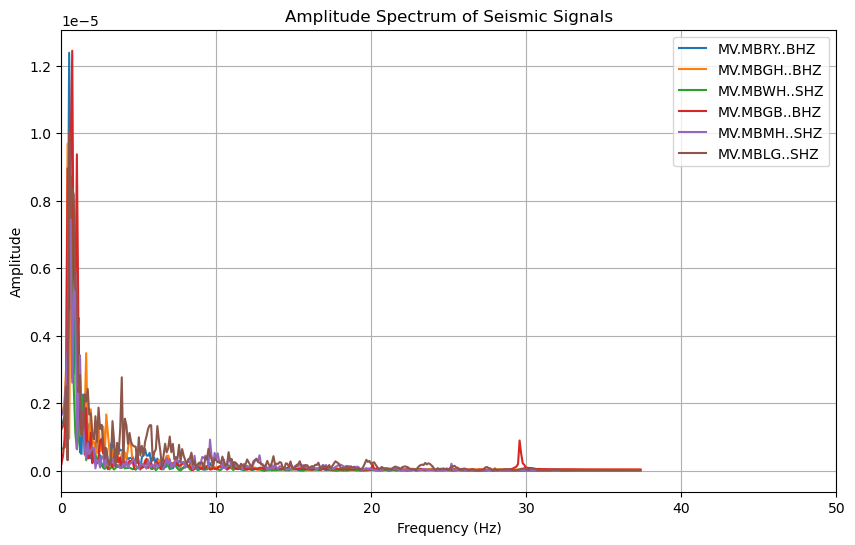

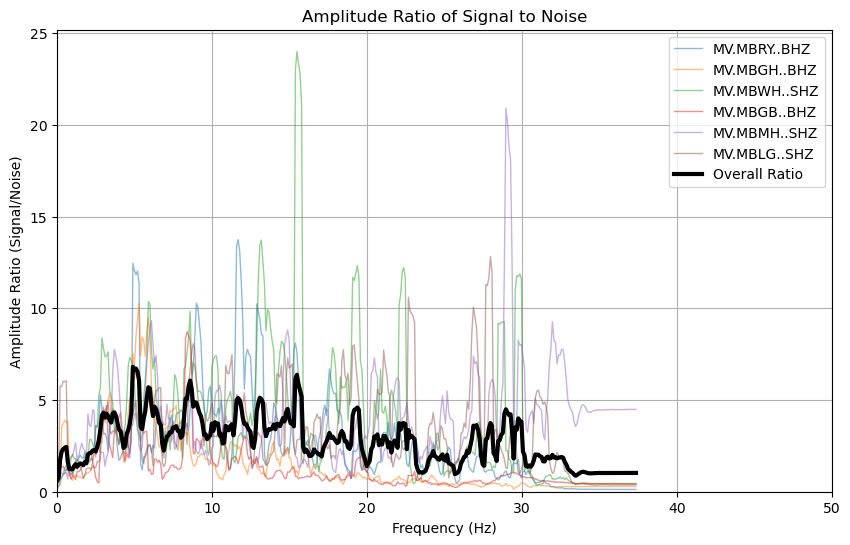

METRIC:  rms
6.2256073439785465e-09
6.8789589179612154e-09
4.2760617631015156e-09
6.220203774807955e-09
5.482190320120899e-09
7.0475003679965476e-09
1.0757870286130885e-08
1.0257451172404057e-08
8.381234387819267e-09
9.15273725048262e-09
8.685512810051963e-09
1.1087101251206005e-08
1.3469919380460479e-09
1.8494631117031855e-09
3.390510925999527e-10
1.0940996287985084e-09
2.675499707174956e-09
4.144048311075044e-09
-62.26279285766937 -62.09570683211882 16.66618354263072 16.826183542630716
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1539-08L.S200103; WAVfile: None

Sfile: 01-1600-04L.S200103; WAVfile: 2001-03-01-1600-04S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T16:00:04.040000Z - 2001-03-01T16:01:19.026667Z | 75.0 Hz, 5625 samples
MV.MBSS..SHZ | 2001-03-01T16:00:04.040000Z - 2001-03-01T16:01:19.026667Z | 75.0 Hz, 5625 samples
MV.MBBY..BHZ | 2001-03-01T16:00:04.040000Z - 2001-03-01T16:01:19.026667Z | 75.0 Hz, 5625 samples
MV.MBGH..BHZ | 

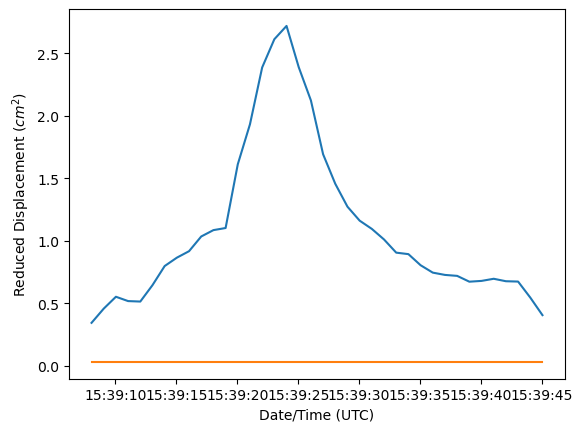

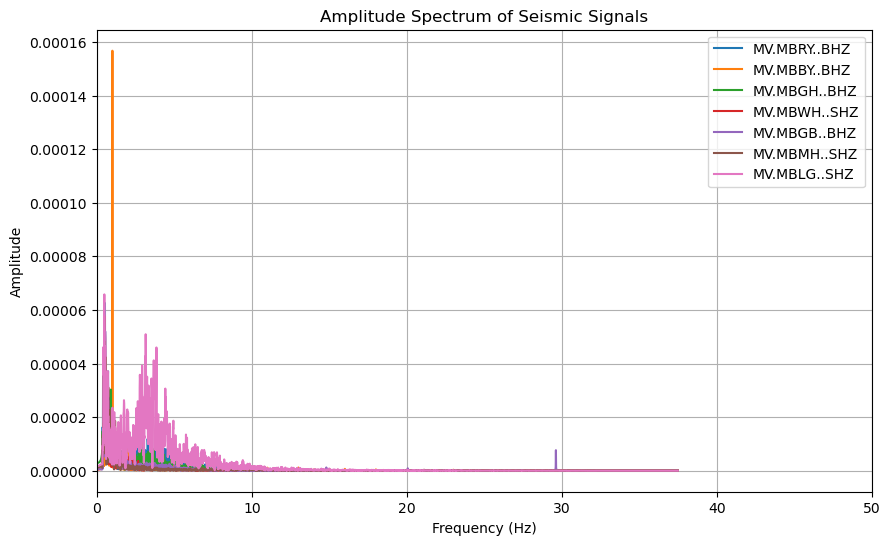

{'cft_peak_wmean': 5.640701560635438,
 'cft_peaks': [7.007636566331839,
               4.70121401184842,
               4.74695246558309,
               6.1070031987784015],
 'cft_std_wmean': 0.989121109545334,
 'cft_stds': [1.3201828669163422,
              0.89038153673331,
              0.8123816934704152,
              0.9335383410612689],
 'coincidence_sum': 4.0,
 'duration': 25.613333344459534,
 'similarity': {},
 'stations': ['MBLG', 'MBMH', 'MBRY', 'MBGH'],
 'time': UTCDateTime(2001, 3, 1, 16, 0, 15, 253333),
 'trace_ids': ['MV.MBLG..SHZ', 'MV.MBMH..SHZ', 'MV.MBRY..BHZ', 'MV.MBGH..BHZ']}
Sfile: 01-1600-04L.S200103; WAVfile: None

Sfile: 01-1614-23L.S200103; WAVfile: 2001-03-01-1614-23S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T16:14:23.040000Z - 2001-03-01T16:15:41.026667Z | 75.0 Hz, 5850 samples
MV.MBSS..SHZ | 2001-03-01T16:14:23.040000Z - 2001-03-01T16:15:41.026667Z | 75.0 Hz, 5850 samples
MV.MBBY..BHZ | 2001-03-01T16:14:23.040000Z - 2001-03-01T16:15:41.02666

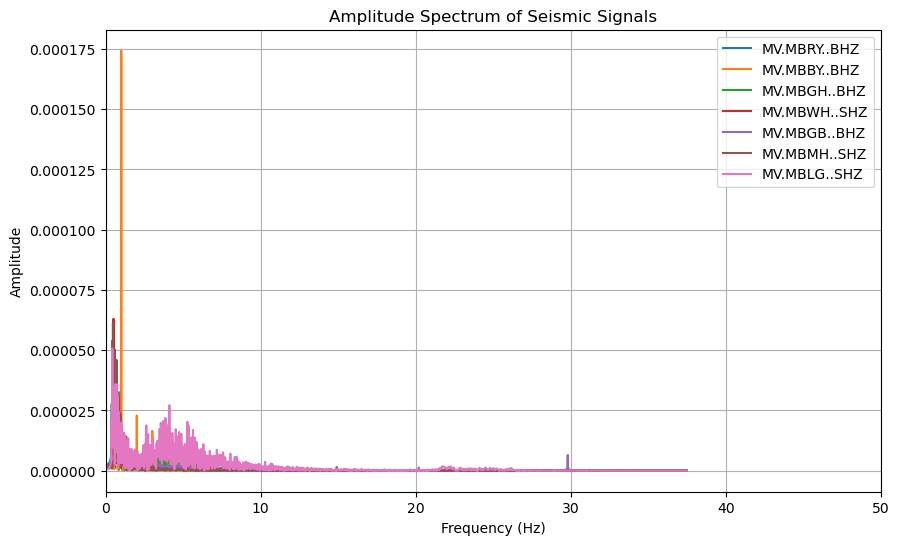

{'cft_peak_wmean': 4.020205024408405,
 'cft_peaks': [4.232794315965662,
               3.8018670109911903,
               3.7973207157167477,
               4.2258254600375205,
               4.043217619330902],
 'cft_std_wmean': 0.9360045886985112,
 'cft_stds': [1.1876287718550107,
              0.7187112226568191,
              0.654882390860793,
              0.8104640178669591,
              1.3083365402529743],
 'coincidence_sum': 5.0,
 'duration': 54.87999999523163,
 'similarity': {},
 'stations': ['MBGB', 'MBLG', 'MBRY', 'MBMH', 'MBGH'],
 'time': UTCDateTime(2001, 3, 1, 16, 14, 33, 426667),
 'trace_ids': ['MV.MBGB..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBMH..SHZ',
               'MV.MBGH..BHZ']}


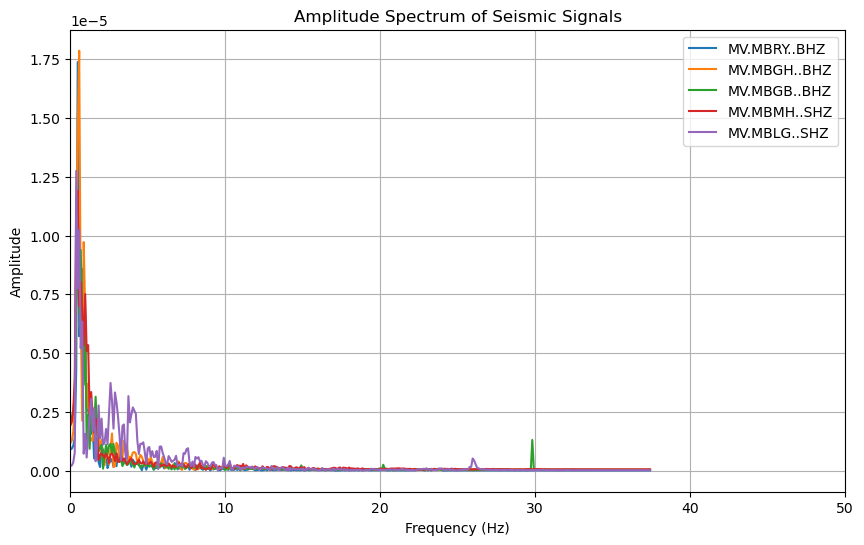

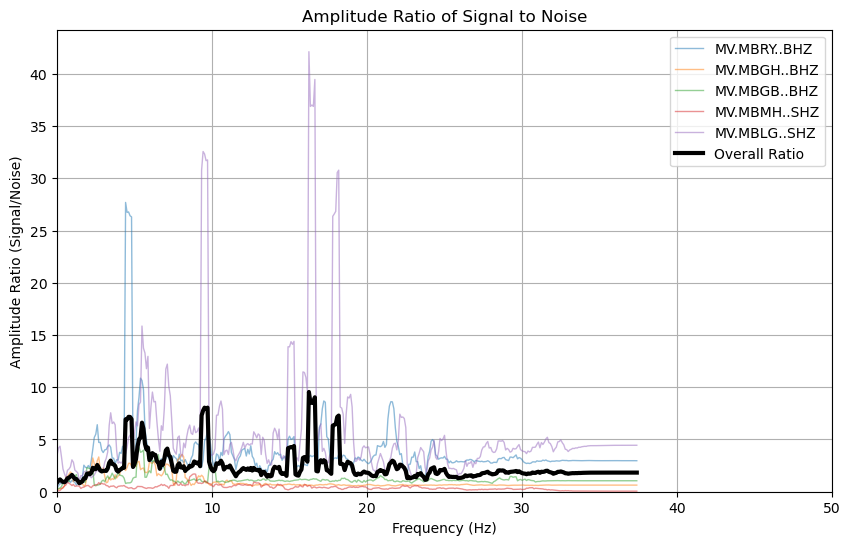

METRIC:  rms
5.805596690165998e-09
4.776025768836015e-09
3.0631627921111984e-09
3.230684104743929e-09
8.833755502545223e-09
7.759589789272891e-09
8.572589079178307e-09
7.605039869602567e-09
4.424391737189249e-09
1.1892027953241201e-08
1.6847764265010304e-09
1.4821347791026314e-09
8.975638379253907e-10
9.278801232752997e-10
3.999335736848602e-09
-62.26988824630862 -62.10282035773765 16.645499145694618 16.805499145694615
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1614-23L.S200103; WAVfile: None

Sfile: 01-1618-37L.S200103; WAVfile: 2001-03-01-1618-37S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T16:18:37.040000Z - 2001-03-01T16:20:24.026667Z | 75.0 Hz, 8025 samples
MV.MBSS..SHZ | 2001-03-01T16:18:37.040000Z - 2001-03-01T16:20:24.026667Z | 75.0 Hz, 8025 samples
MV.MBBY..BHZ | 2001-03-01T16:18:37.040000Z - 2001-03-01T16:20:24.026667Z | 75.0 Hz, 8025 samples
MV.MBGH..BHZ | 2001-03-01T16:18:37.040000Z - 2001-03-01T16:20:24.026667Z | 75.0 Hz, 8

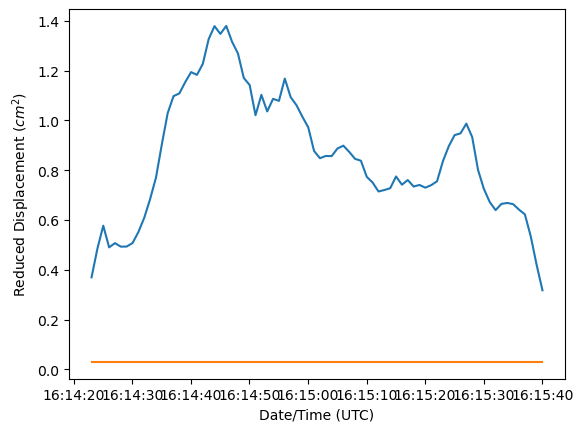

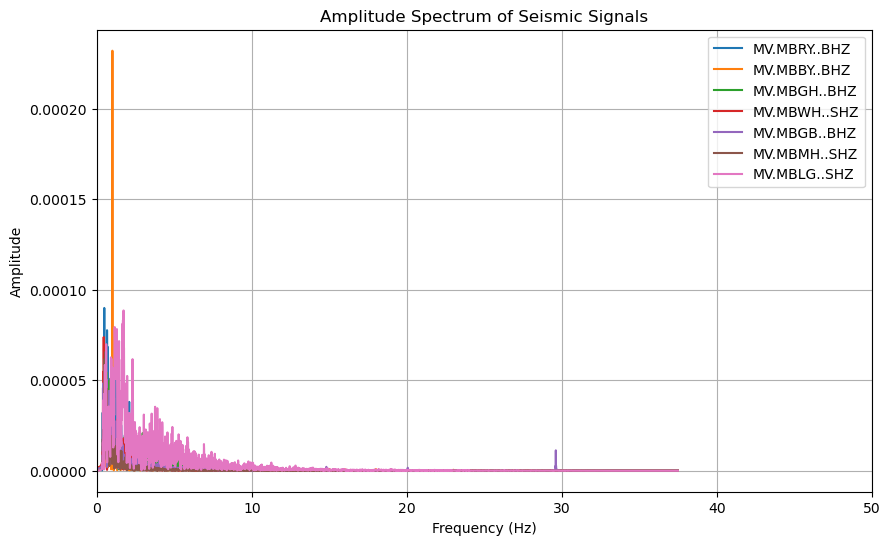

{'cft_peak_wmean': 5.326644875327278,
 'cft_peaks': [3.6850767908064563,
               10.143390063727795,
               3.8158815703447,
               4.077876674319988,
               6.555280989126929,
               3.682363163637802],
 'cft_std_wmean': 0.9677560713997312,
 'cft_stds': [0.6298301269742704,
              1.373005265721775,
              0.707948145888066,
              1.2575693230191527,
              1.0737928075818315,
              0.7643907592132908],
 'coincidence_sum': 6.0,
 'duration': 46.986666679382324,
 'similarity': {},
 'stations': ['MBGB', 'MBLG', 'MBGH', 'MBWH', 'MBRY', 'MBMH'],
 'time': UTCDateTime(2001, 3, 1, 16, 18, 48, 266667),
 'trace_ids': ['MV.MBGB..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBGH..BHZ',
               'MV.MBWH..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBMH..SHZ']}


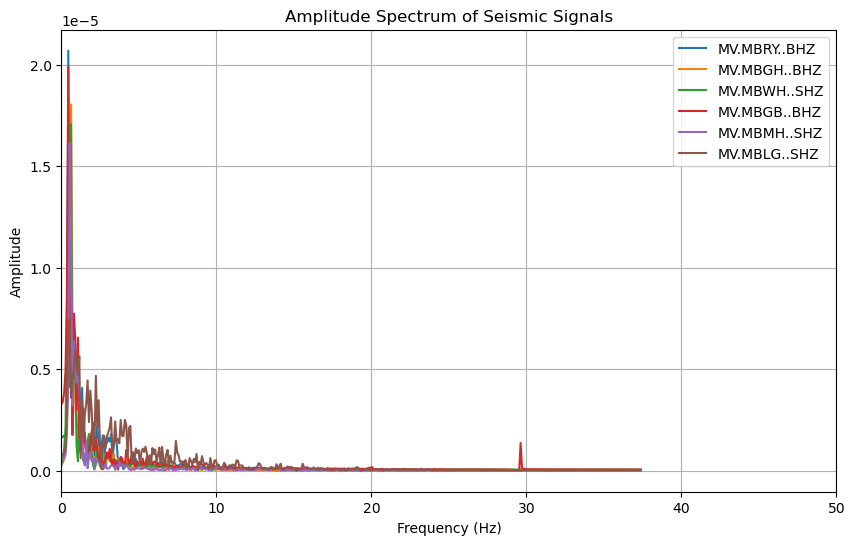

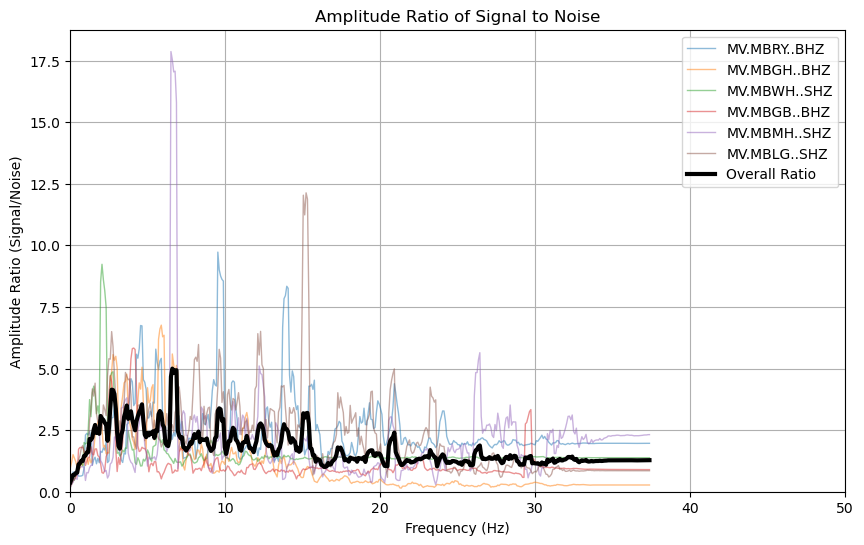

METRIC:  rms
5.90337032122779e-09
6.388406744230361e-09
2.753172163808565e-09
5.0231676069864016e-09
4.055801633356005e-09
1.167098227593393e-08
9.208104044380634e-09
5.496388716093104e-09
6.944344416222171e-09
7.821441761870949e-09
5.649290375444036e-09
1.3982567351740924e-08
9.47483637951774e-10
1.2150898216584868e-09
2.550705675309099e-10
1.0734677975255956e-09
8.760667943565263e-10
2.935559536310296e-09
-62.27597502356698 -62.108912649843354 16.639203894453196 16.799203894453193
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1618-37L.S200103; WAVfile: None

Sfile: 01-1639-44L.S200103; WAVfile: 2001-03-01-1639-44S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T16:39:44.040000Z - 2001-03-01T16:40:44.026667Z | 75.0 Hz, 4500 samples
MV.MBSS..SHZ | 2001-03-01T16:39:44.040000Z - 2001-03-01T16:40:44.026667Z | 75.0 Hz, 4500 samples
MV.MBBY..BHZ | 2001-03-01T16:39:44.040000Z - 2001-03-01T16:40:44.026667Z | 75.0 Hz, 4500 samples
MV.MBGH..BHZ | 2001-

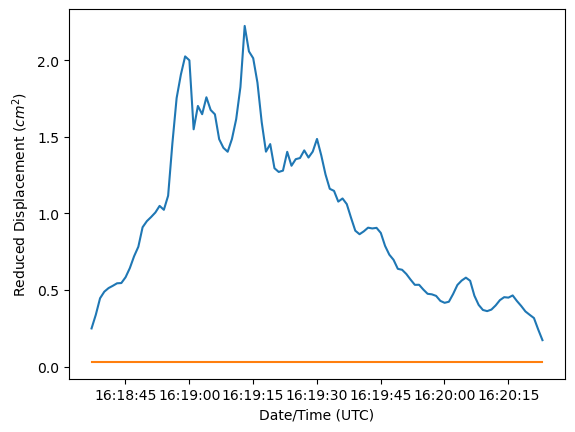

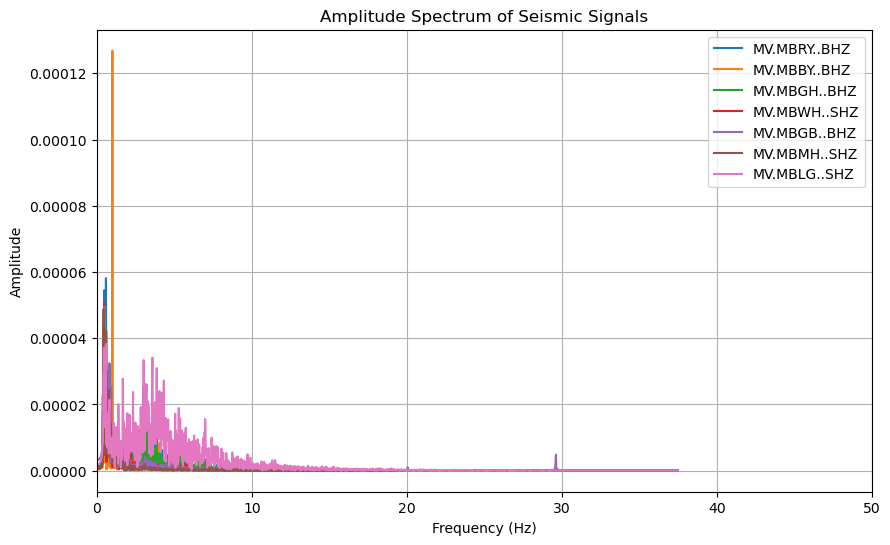

{'cft_peak_wmean': 4.577995390153353,
 'cft_peaks': [3.8241209259777995,
               5.474097655750587,
               4.067790475542274,
               6.011239543627787,
               3.5127283498683153],
 'cft_std_wmean': 0.8689224230722662,
 'cft_stds': [0.6781381282332406,
              1.3679006655966666,
              0.6107402087716096,
              0.8190924651377265,
              0.8687406476220874],
 'coincidence_sum': 5.0,
 'duration': 49.94666659832001,
 'similarity': {},
 'stations': ['MBWH', 'MBMH', 'MBLG', 'MBRY', 'MBGB'],
 'time': UTCDateTime(2001, 3, 1, 16, 39, 54, 80000),
 'trace_ids': ['MV.MBWH..SHZ',
               'MV.MBMH..SHZ',
               'MV.MBLG..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBGB..BHZ']}


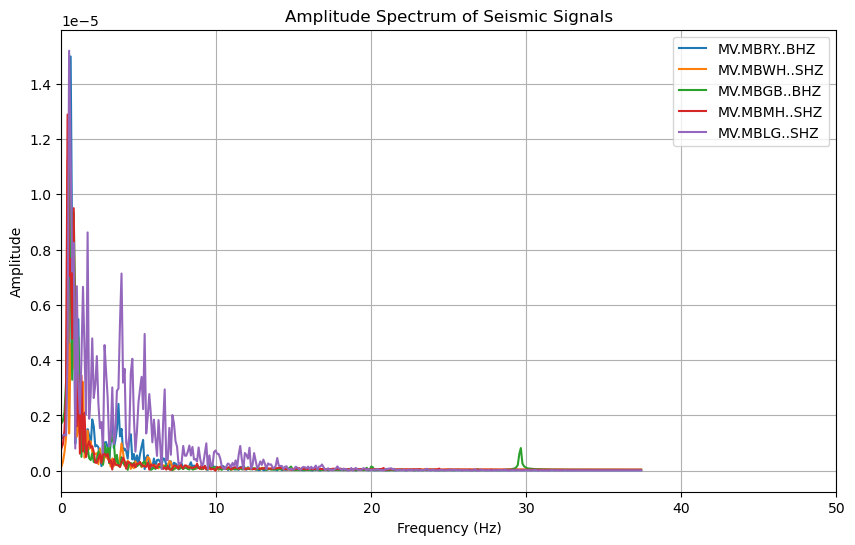

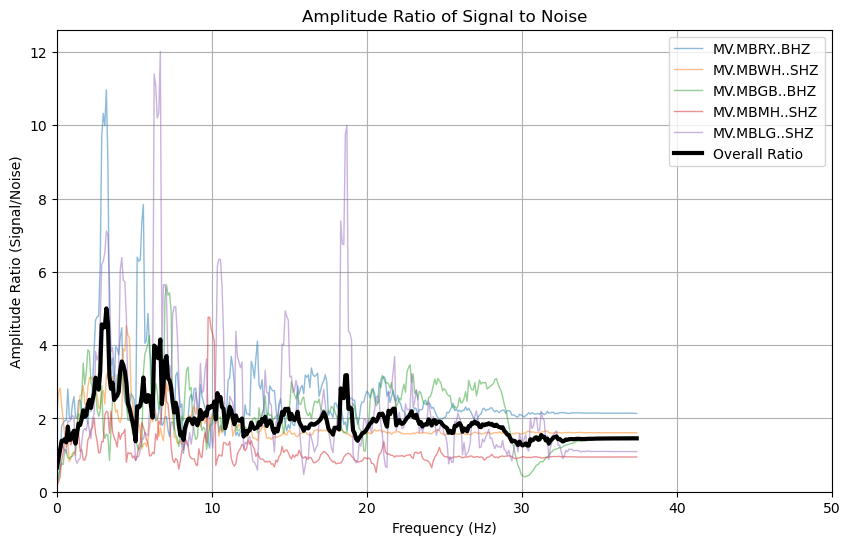

METRIC:  rms
7.0945615462448424e-09
3.947271299391951e-09
3.282926313077474e-09
3.5299438384308525e-09
1.3972105178873618e-08
1.0021876799486727e-08
3.904339981587875e-09
6.433226753062533e-09
6.792489975797666e-09
1.8983475247512088e-08
2.7547526366682708e-09
6.360095272009965e-10
9.893853304344877e-10
8.53843147388258e-10
5.944542133838894e-09
-62.27495970729948 -62.10789812121684 16.63830457284728 16.798304572847275
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1639-44L.S200103; WAVfile: None

Sfile: 01-1646-15L.S200103; WAVfile: 2001-03-01-1646-15S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T16:46:15.040000Z - 2001-03-01T16:47:33.026667Z | 75.0 Hz, 5850 samples
MV.MBSS..SHZ | 2001-03-01T16:46:15.040000Z - 2001-03-01T16:47:33.026667Z | 75.0 Hz, 5850 samples
MV.MBBY..BHZ | 2001-03-01T16:46:15.040000Z - 2001-03-01T16:47:33.026667Z | 75.0 Hz, 5850 samples
MV.MBGH..BHZ | 2001-03-01T16:46:15.040000Z - 2001-03-01T16:47:33.026667Z | 75.0 Hz, 5

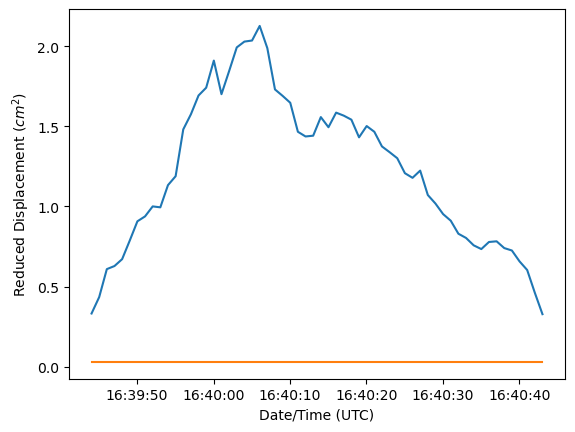

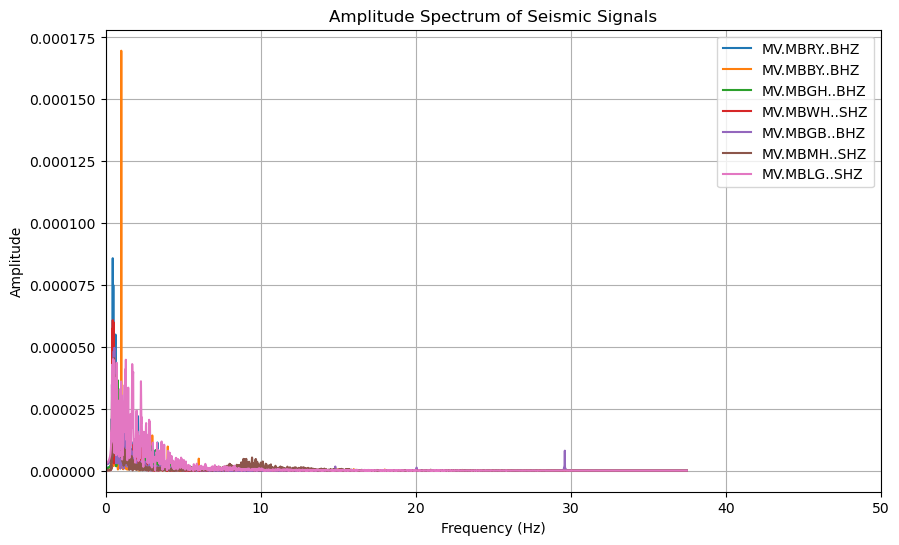

{'cft_peak_wmean': 5.604109784335272,
 'cft_peaks': [3.757486159190819,
               8.3491994890165,
               7.397797370884135,
               5.35658620845275,
               4.221972404214949,
               4.541617074252479],
 'cft_std_wmean': 1.0768982553577897,
 'cft_stds': [0.758048791519313,
              1.7589524038463034,
              1.3334434750649538,
              0.9574577601060432,
              0.7515318368945434,
              0.9019552647155817],
 'coincidence_sum': 6.0,
 'duration': 25.02666664123535,
 'similarity': {},
 'stations': ['MBMH', 'MBLG', 'MBRY', 'MBWH', 'MBGB', 'MBGH'],
 'time': UTCDateTime(2001, 3, 1, 16, 46, 25, 453333),
 'trace_ids': ['MV.MBMH..SHZ',
               'MV.MBLG..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBWH..SHZ',
               'MV.MBGB..BHZ',
               'MV.MBGH..BHZ']}


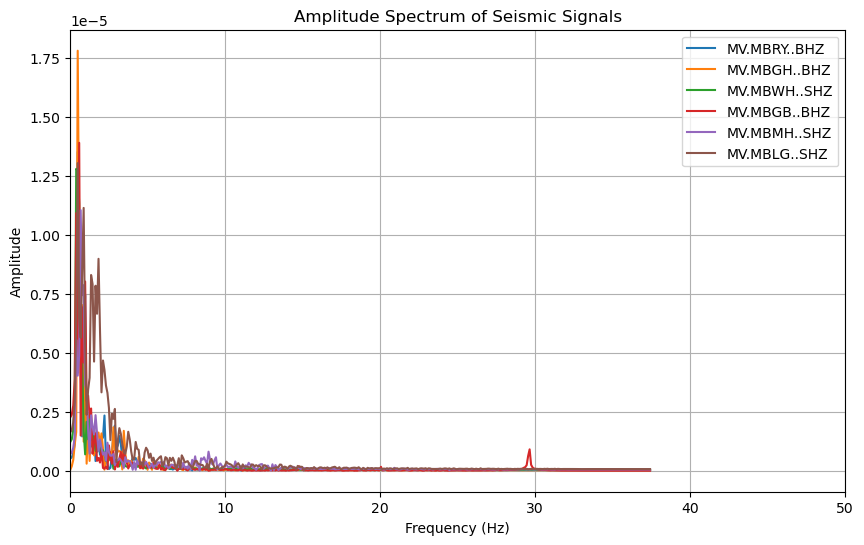

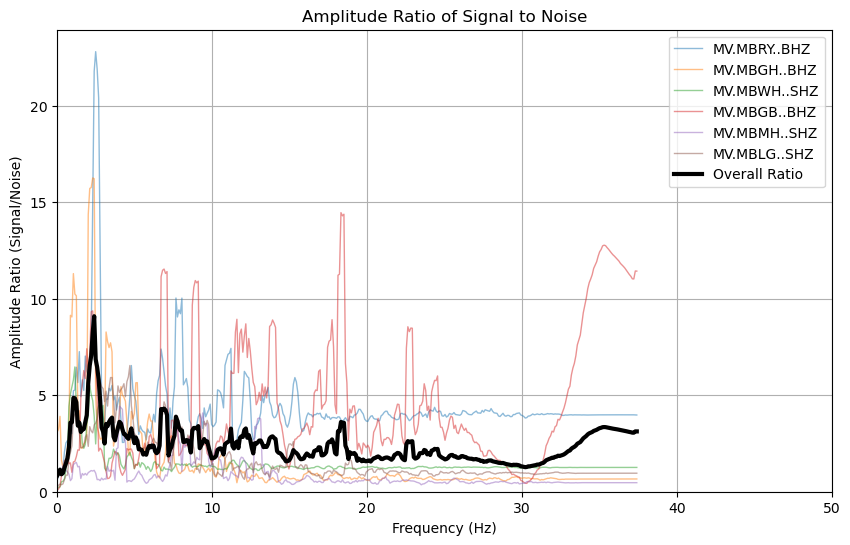

METRIC:  rms
4.600946047748094e-09
5.5632376136224e-09
4.361029288221806e-09
4.095729848736122e-09
6.052497164566585e-09
6.71137023976997e-09
8.147226271596473e-09
9.339285241071213e-09
7.591603120601271e-09
5.8385723628264036e-09
9.156056829794214e-09
1.0437608729956644e-08
6.36298454138187e-10
8.895160537122701e-10
2.8638681815027756e-10
7.603700390168428e-10
1.2925443074413494e-09
1.748616347060716e-09
-62.25365855564632 -62.08657253009577 16.66618354263072 16.826183542630716
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1646-15L.S200103; WAVfile: None

Sfile: 01-1736-45L.S200103; WAVfile: 2001-03-01-1736-45S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T17:36:45.040000Z - 2001-03-01T17:37:52.026667Z | 75.0 Hz, 5025 samples
MV.MBSS..SHZ | 2001-03-01T17:36:45.040000Z - 2001-03-01T17:37:52.026667Z | 75.0 Hz, 5025 samples
MV.MBBY..BHZ | 2001-03-01T17:36:45.040000Z - 2001-03-01T17:37:52.026667Z | 75.0 Hz, 5025 samples
MV.MBGH..BHZ | 2001-03-0

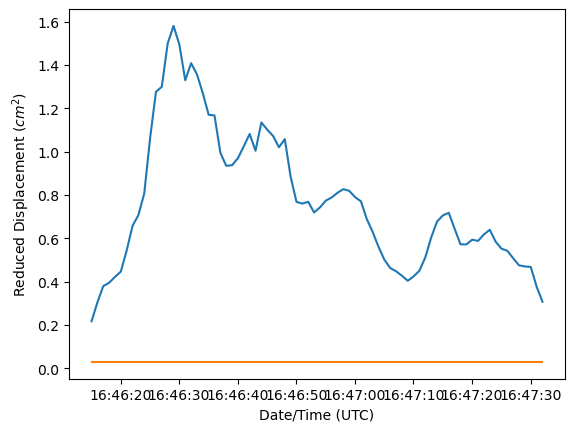

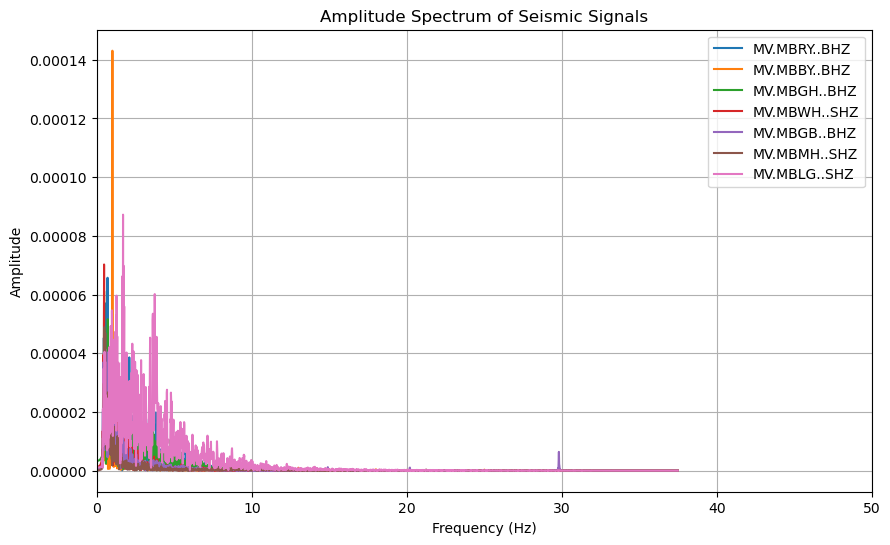

{'cft_peak_wmean': 6.0073454267832,
 'cft_peaks': [12.397986690302613,
               3.64718819870003,
               4.3423113761084,
               5.170906667740914,
               4.848405279187597,
               5.637274348659643],
 'cft_std_wmean': 0.9302372351476097,
 'cft_stds': [1.6153729683084934,
              0.8808263310920125,
              0.6908641962466302,
              0.7819657848860281,
              0.7131286452568727,
              0.8992654850956213],
 'coincidence_sum': 6.0,
 'duration': 55.733333468437195,
 'similarity': {},
 'stations': ['MBLG', 'MBWH', 'MBRY', 'MBGB', 'MBGH', 'MBMH'],
 'time': UTCDateTime(2001, 3, 1, 17, 36, 55, 40000),
 'trace_ids': ['MV.MBLG..SHZ',
               'MV.MBWH..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBGB..BHZ',
               'MV.MBGH..BHZ',
               'MV.MBMH..SHZ']}


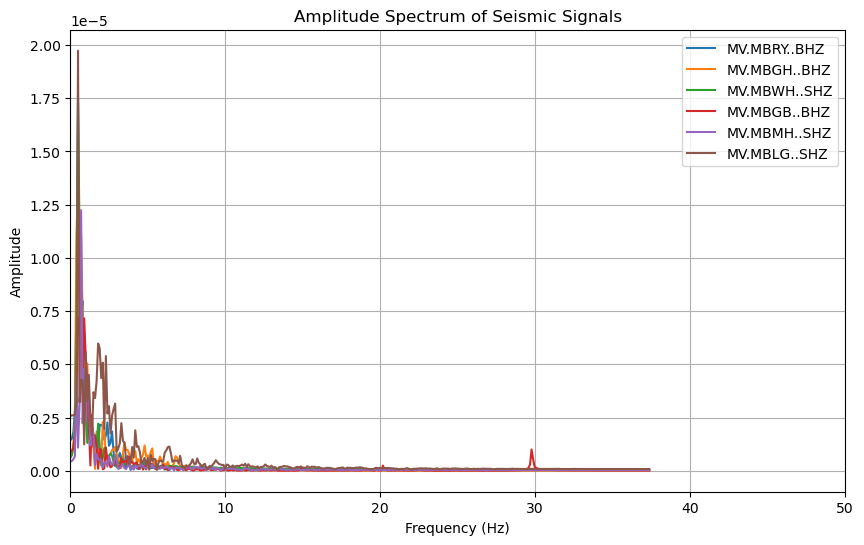

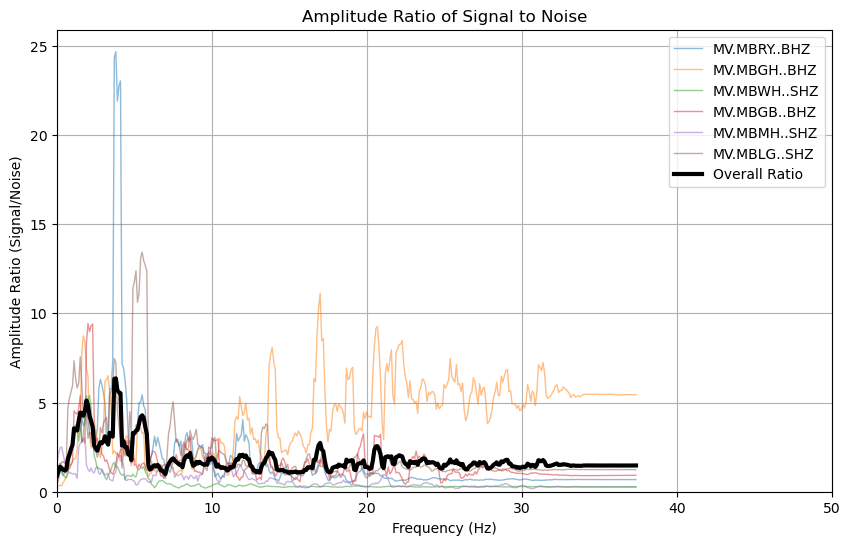

METRIC:  rms
8.40362292248787e-09
7.226835604847945e-09
4.266150820916242e-09
7.038270967124003e-09
5.0716604121030015e-09
8.757596741367026e-09
1.0271449711153597e-08
1.0478759677189385e-08
7.87395185723647e-09
1.1647603099777446e-08
7.637520935739683e-09
1.393892282801701e-08
1.1089330998696876e-09
2.3113995931460972e-09
3.056141735273458e-10
8.948416650000815e-10
9.11598784915947e-10
2.6446360080014083e-09
-62.2668434789676 -62.09977559039663 16.645499145694618 16.805499145694615
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1736-45L.S200103; WAVfile: None

Sfile: 01-1833-32L.S200103; WAVfile: 2001-03-01-1833-32S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T18:33:32.040000Z - 2001-03-01T18:34:26.026667Z | 75.0 Hz, 4050 samples
MV.MBSS..SHZ | 2001-03-01T18:33:32.040000Z - 2001-03-01T18:34:26.026667Z | 75.0 Hz, 4050 samples
MV.MBBY..BHZ | 2001-03-01T18:33:32.040000Z - 2001-03-01T18:34:26.026667Z | 75.0 Hz, 4050 samples
MV.MBGH..BHZ | 2001-

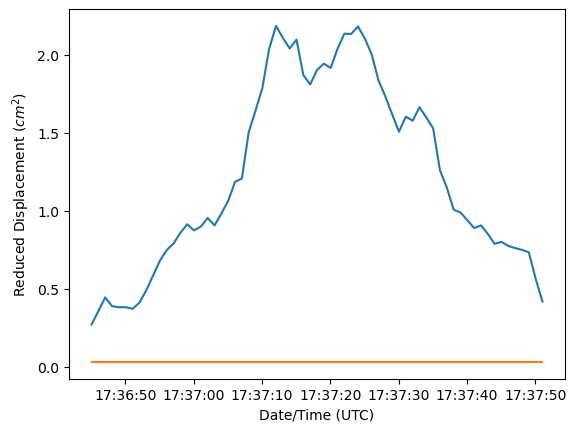

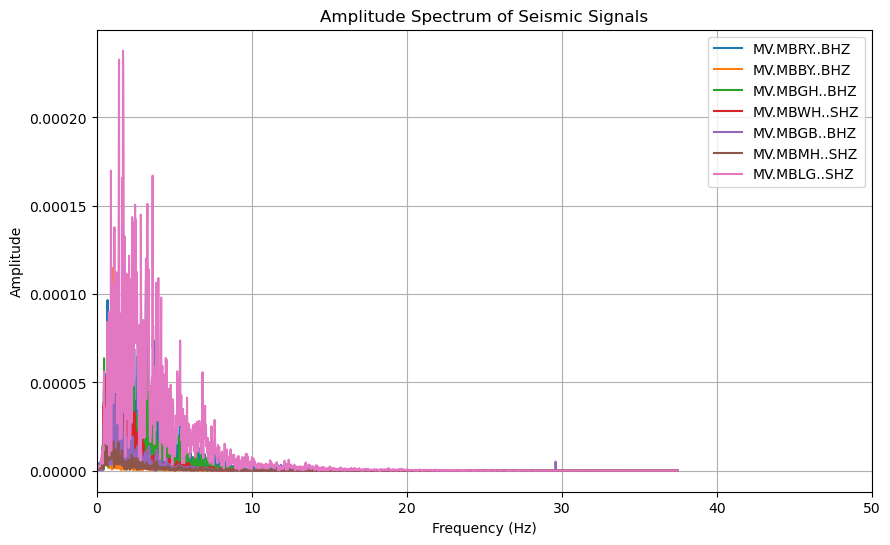

{'cft_peak_wmean': 4.9738709512126915,
 'cft_peaks': [5.807834020557567,
               3.6315001551571213,
               5.445463943602591,
               3.925165511881263,
               5.776522752635762,
               5.256739323441843],
 'cft_std_wmean': 0.9258865730788025,
 'cft_stds': [0.868078687020772,
              0.6878185223498786,
              1.1224797763439047,
              0.9108697892295102,
              0.9390455044508919,
              1.027027159077858],
 'coincidence_sum': 6.0,
 'duration': 33.37333345413208,
 'similarity': {},
 'stations': ['MBMH', 'MBGH', 'MBGB', 'MBRY', 'MBLG', 'MBWH'],
 'time': UTCDateTime(2001, 3, 1, 18, 33, 42, 40000),
 'trace_ids': ['MV.MBMH..SHZ',
               'MV.MBGH..BHZ',
               'MV.MBGB..BHZ',
               'MV.MBRY..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBWH..SHZ']}


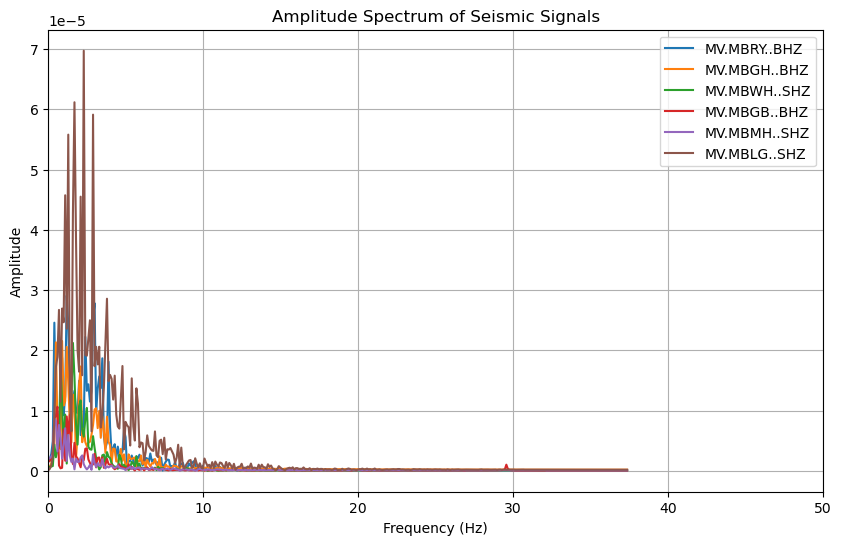

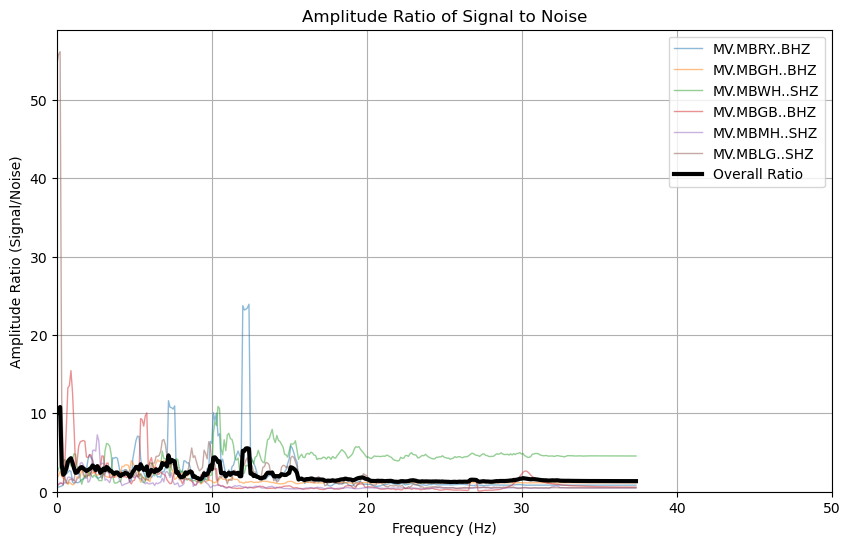

METRIC:  rms
2.7477570427689148e-08
3.06307456228738e-08
1.976265972944126e-08
1.7658485087435112e-08
7.745848849350107e-09
7.921672167506855e-08
3.811265631947261e-08
4.08873601980406e-08
3.181811100278565e-08
2.785265472772832e-08
1.0495421233205259e-08
9.847879887537055e-08
1.1164056503550788e-08
8.053272262106934e-09
3.904907365119706e-09
2.9189813070468283e-09
1.900922248104183e-09
3.2933465486041766e-08
-62.267855643990934 -62.10079327026731 16.639203894453196 16.799203894453193
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1833-32L.S200103; WAVfile: None

Sfile: 01-1858-06L.S200103; WAVfile: 2001-03-01-1858-06S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T18:58:06.040000Z - 2001-03-01T18:59:21.026667Z | 75.0 Hz, 5625 samples
MV.MBSS..SHZ | 2001-03-01T18:58:06.040000Z - 2001-03-01T18:59:21.026667Z | 75.0 Hz, 5625 samples
MV.MBBY..BHZ | 2001-03-01T18:58:06.040000Z - 2001-03-01T18:59:21.026667Z | 75.0 Hz, 5625 samples
MV.MBGH..BHZ | 200

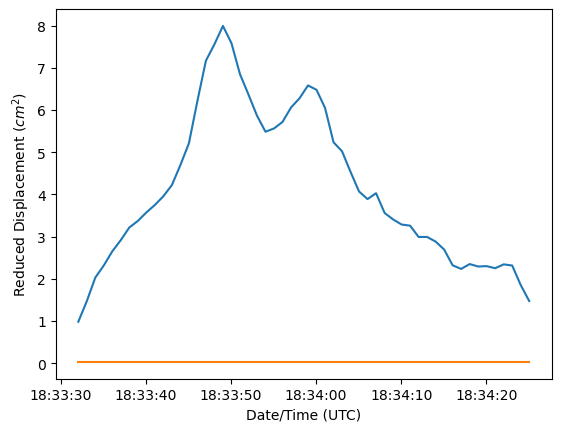

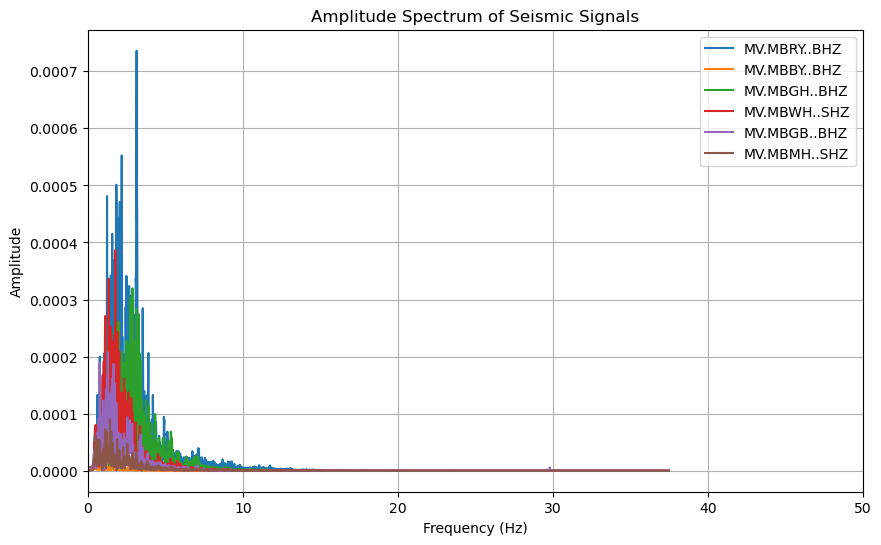

{'cft_peak_wmean': 6.690572488821504,
 'cft_peaks': [6.296704249040074,
               7.026099880431684,
               7.546923624316372,
               6.843406572474321,
               5.739728117845063],
 'cft_std_wmean': 1.1507124814011749,
 'cft_stds': [1.1085481305793687,
              1.0473796673722284,
              1.1056746306078928,
              1.4641406369228065,
              1.0278193415235788],
 'coincidence_sum': 5.0,
 'duration': 40.8400000333786,
 'similarity': {},
 'stations': ['MBRY', 'MBGB', 'MBMH', 'MBWH', 'MBGH'],
 'time': UTCDateTime(2001, 3, 1, 18, 58, 16, 40000),
 'trace_ids': ['MV.MBRY..BHZ',
               'MV.MBGB..BHZ',
               'MV.MBMH..SHZ',
               'MV.MBWH..SHZ',
               'MV.MBGH..BHZ']}


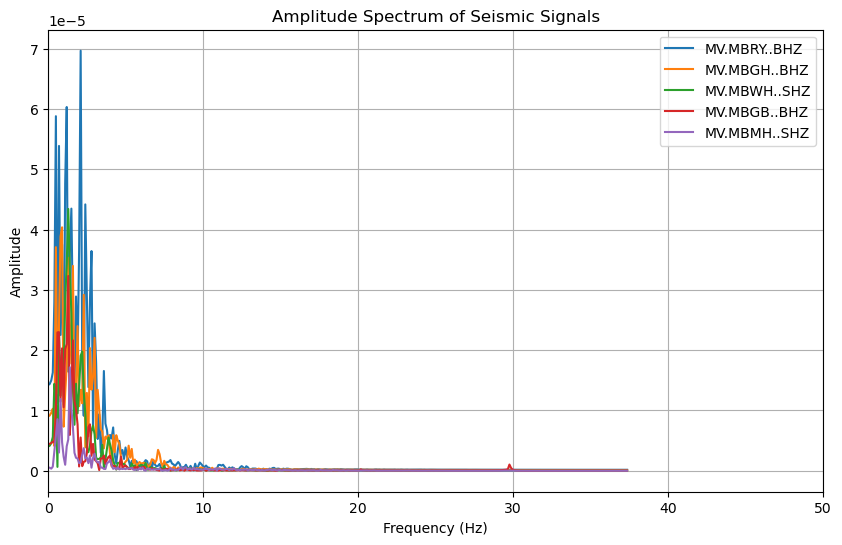

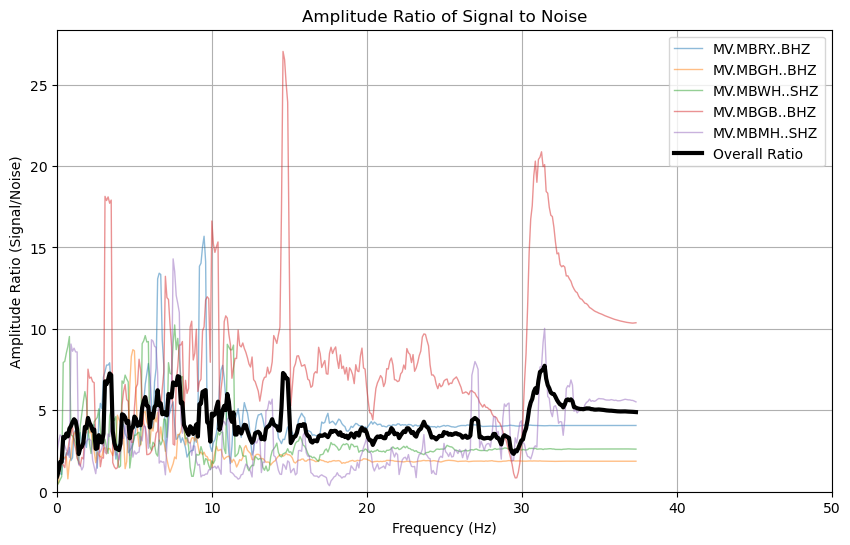

METRIC:  rms
6.372232786218148e-08
5.099431956809305e-08
3.5445443605414665e-08
2.0101094052473723e-08
1.2998782346864847e-08
1.213403468138855e-07
7.308355439420885e-08
4.7734383858808296e-08
4.168321652999168e-08
2.0397100275524448e-08
1.7395290502717192e-08
1.587672854881009e-08
5.89607832451705e-09
3.0374603329045297e-09
3.4922445497649067e-09
-62.26379910564144 -62.09673042904076 16.646398467300536 16.806398467300532
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1858-06L.S200103; WAVfile: None

Sfile: 01-1927-20L.S200103; WAVfile: 2001-03-01-1927-20S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T19:27:20.040000Z - 2001-03-01T19:29:02.026667Z | 75.0 Hz, 7650 samples
MV.MBSS..SHZ | 2001-03-01T19:27:20.040000Z - 2001-03-01T19:29:02.026667Z | 75.0 Hz, 7650 samples
MV.MBBY..BHZ | 2001-03-01T19:27:20.040000Z - 2001-03-01T19:29:02.026667Z | 75.0 Hz, 7650 samples
MV.MBGH..BHZ | 2001-03-01T19:27:20.040000Z - 2001-03-01T19:29:02.026667Z | 75.0 Hz

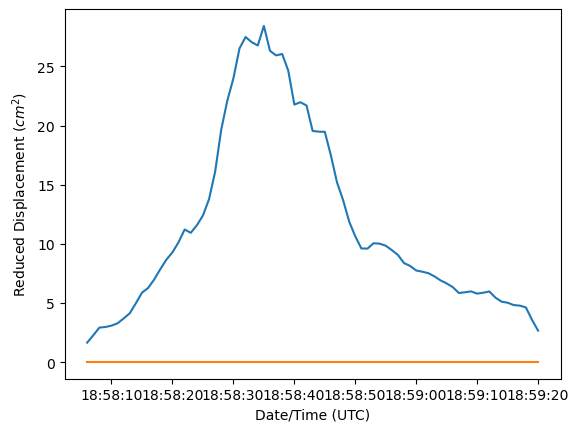

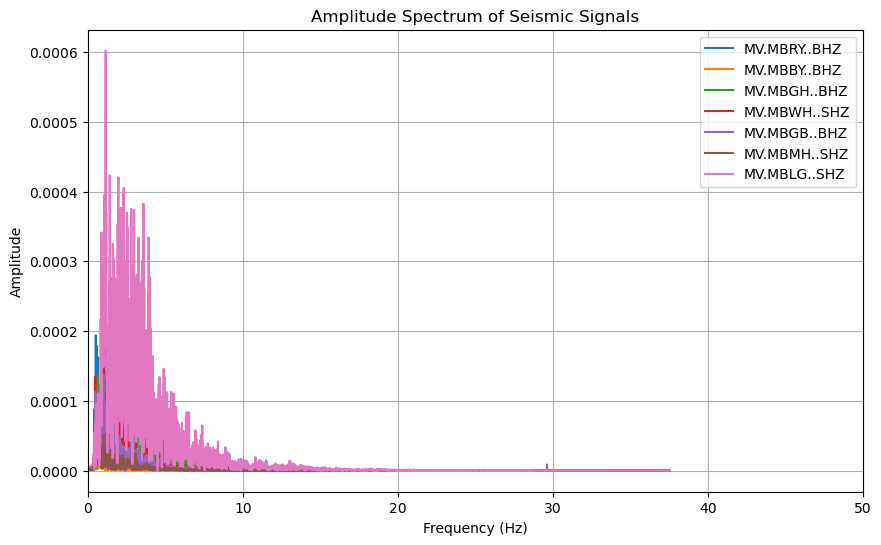

{'cft_peak_wmean': 8.824988012352913,
 'cft_peaks': [10.363104972992655,
               12.380485243362617,
               5.913739456783262,
               8.563013388142172,
               8.32052892005417,
               7.409056092782607],
 'cft_std_wmean': 1.7821309704721655,
 'cft_stds': [2.1021702211250997,
              2.806814069669155,
              0.9223323992552975,
              1.0630270142370537,
              2.0810412209732663,
              1.7174008975731225],
 'coincidence_sum': 6.0,
 'duration': 52.61333346366882,
 'similarity': {},
 'stations': ['MBGH', 'MBWH', 'MBRY', 'MBLG', 'MBGB', 'MBMH'],
 'time': UTCDateTime(2001, 3, 1, 19, 27, 30, 40000),
 'trace_ids': ['MV.MBGH..BHZ',
               'MV.MBWH..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBGB..BHZ',
               'MV.MBMH..SHZ']}


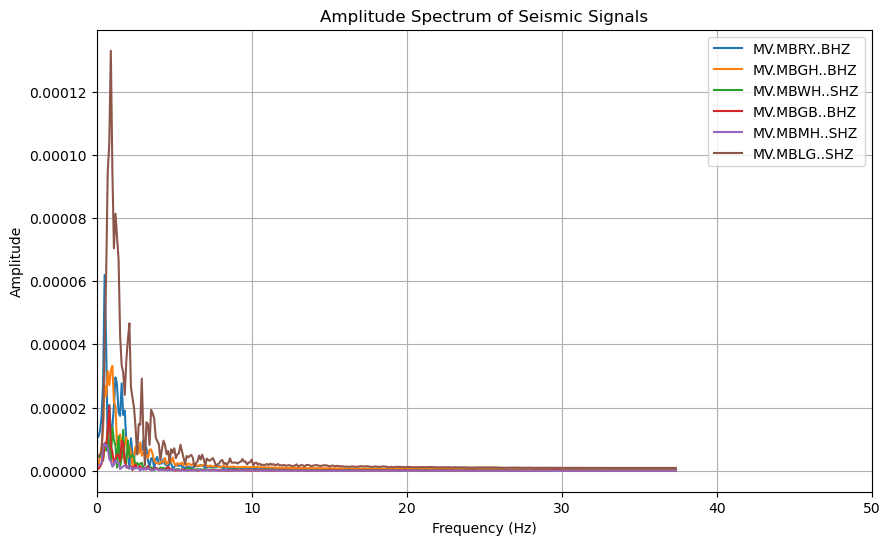

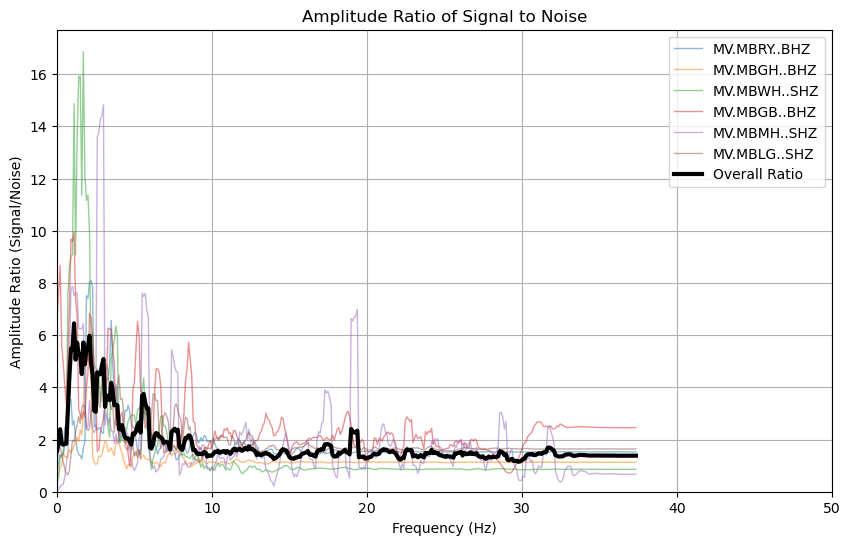

METRIC:  rms
2.8396342880716752e-08
1.919387041996007e-08
1.5996115241566187e-08
1.7121242654344697e-08
7.4002440416108005e-09
6.673601037037128e-08
3.540839189806209e-08
2.7505460687209816e-08
2.524355210588623e-08
2.1778351453141687e-08
1.1023918843659738e-08
9.279226290699739e-08
7.044237332640913e-09
5.372485185193827e-09
1.6859266819771268e-09
2.0349523824197057e-09
1.9975358433929267e-09
1.7399147622259546e-08
-62.27090041133195 -62.10383803760833 16.639203894453196 16.799203894453193
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1927-20L.S200103; WAVfile: None

Sfile: 01-1955-11L.S200103; WAVfile: 2001-03-01-1955-11S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T19:55:11.040000Z - 2001-03-01T19:56:45.026667Z | 75.0 Hz, 7050 samples
MV.MBSS..SHZ | 2001-03-01T19:55:11.040000Z - 2001-03-01T19:56:45.026667Z | 75.0 Hz, 7050 samples
MV.MBBY..BHZ | 2001-03-01T19:55:11.040000Z - 2001-03-01T19:56:45.026667Z | 75.0 Hz, 7050 samples
MV.MBGH..BHZ

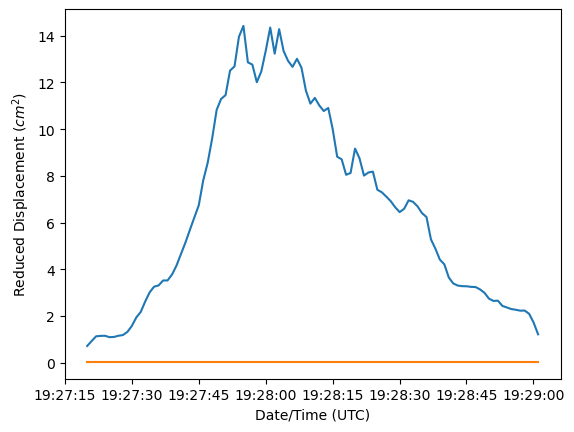

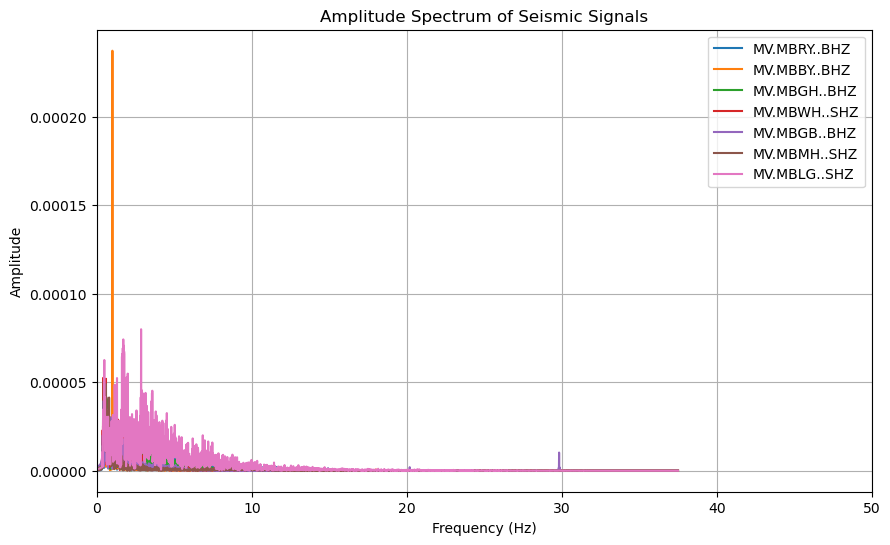

{'cft_peak_wmean': 5.012185769258301,
 'cft_peaks': [6.969503153379539,
               3.8172363173535455,
               6.69129234260625,
               4.322937229367335,
               3.8166981680180734,
               4.45544740482506],
 'cft_std_wmean': 0.9404649274797238,
 'cft_stds': [0.8834477199926327,
              0.9422009187273711,
              1.1242751890240859,
              0.6130498920386052,
              1.0311412814326402,
              1.048674563663009],
 'coincidence_sum': 6.0,
 'duration': 73.49333345890045,
 'similarity': {},
 'stations': ['MBLG', 'MBWH', 'MBRY', 'MBGH', 'MBMH', 'MBGB'],
 'time': UTCDateTime(2001, 3, 1, 19, 55, 21, 40000),
 'trace_ids': ['MV.MBLG..SHZ',
               'MV.MBWH..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBGH..BHZ',
               'MV.MBMH..SHZ',
               'MV.MBGB..BHZ']}


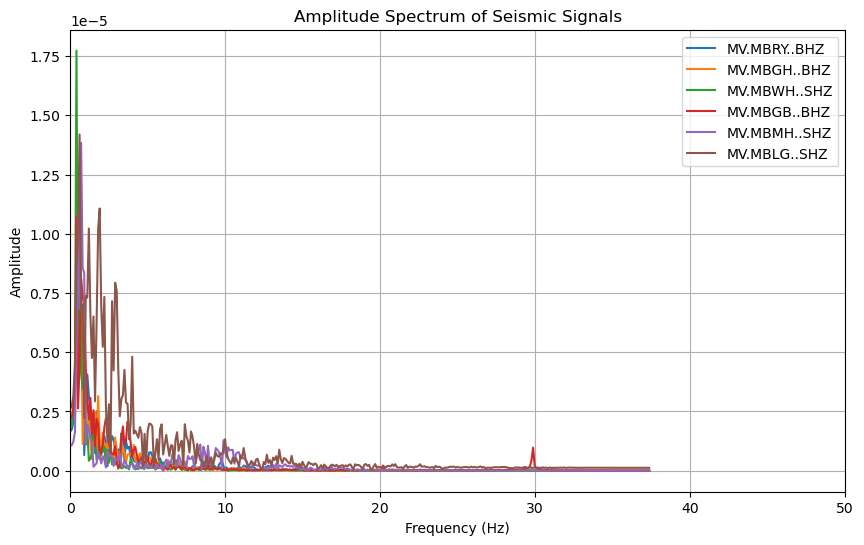

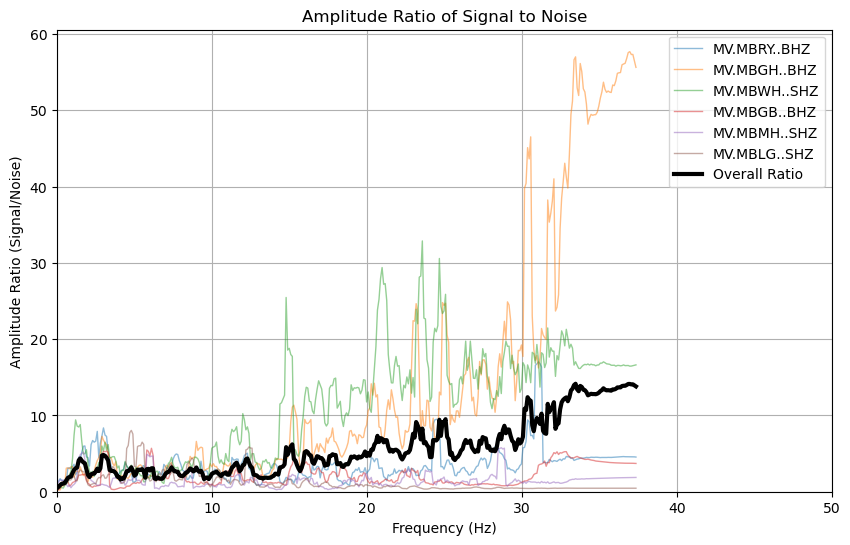

METRIC:  rms
4.820058208282029e-09
1.007285913355578e-08
4.821506796015168e-09
5.707086538619767e-09
4.443056609380501e-09
1.3853863848470065e-08
7.196387565468227e-09
1.4396988596745959e-08
8.404390769964267e-09
1.0151900966953465e-08
6.796886275159964e-09
2.3516963184397322e-08
2.308715628168929e-09
1.5494344594581027e-09
6.845339305334015e-10
1.0393665230302648e-09
1.7199943553313084e-09
6.1376229232367275e-09
-62.26583092097418 -62.09875830349604 16.650895075330123 16.81089507533012
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1955-11L.S200103; WAVfile: None

Sfile: 01-1959-58L.S200103; WAVfile: 2001-03-01-1959-58S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T19:59:58.040000Z - 2001-03-01T20:01:09.026667Z | 75.0 Hz, 5325 samples
MV.MBSS..SHZ | 2001-03-01T19:59:58.040000Z - 2001-03-01T20:01:09.026667Z | 75.0 Hz, 5325 samples
MV.MBBY..BHZ | 2001-03-01T19:59:58.040000Z - 2001-03-01T20:01:09.026667Z | 75.0 Hz, 5325 samples
MV.MBGH..BHZ | 2

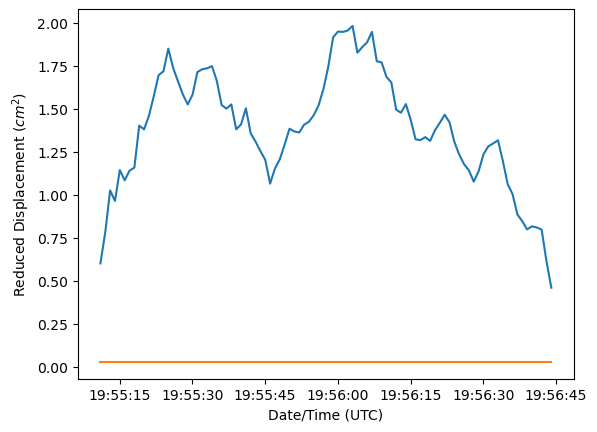

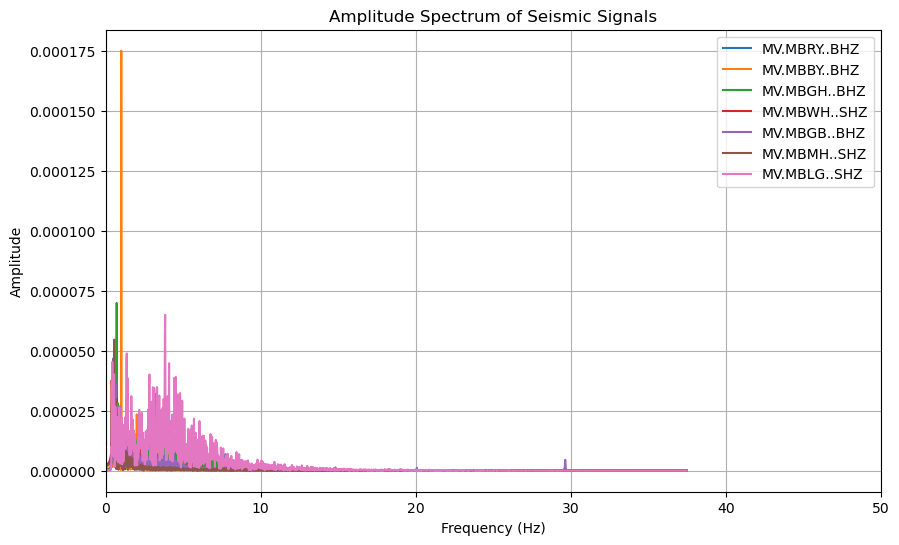

{'cft_peak_wmean': 3.9711337469246866,
 'cft_peaks': [4.241135110269396,
               3.9403910755703517,
               4.162723526352153,
               3.9698447728996875,
               3.5415742495318443],
 'cft_std_wmean': 0.8117016331005077,
 'cft_stds': [0.6942264953214924,
              0.7271655046496578,
              0.5847258476212038,
              1.0964806774187266,
              0.9559096404914577],
 'coincidence_sum': 5.0,
 'duration': 60.986666679382324,
 'similarity': {},
 'stations': ['MBRY', 'MBLG', 'MBGH', 'MBMH', 'MBWH'],
 'time': UTCDateTime(2001, 3, 1, 20, 0, 8, 40000),
 'trace_ids': ['MV.MBRY..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBGH..BHZ',
               'MV.MBMH..SHZ',
               'MV.MBWH..SHZ']}


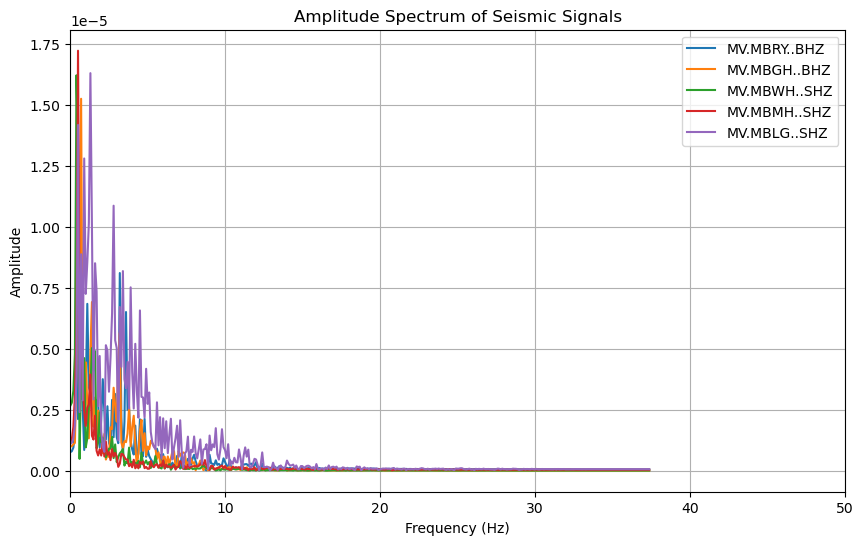

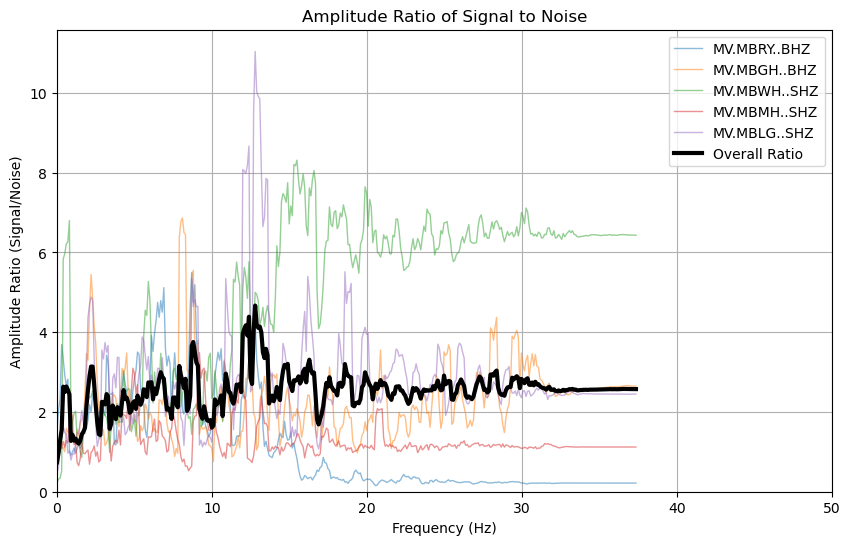

METRIC:  rms
1.001830292901062e-08
1.1094770143431398e-08
5.082530061040896e-09
4.733333521977109e-09
1.2879357813120955e-08
1.4347432907687729e-08
1.117581286329979e-08
8.72979363682799e-09
6.252531310034901e-09
1.7963239250264474e-08
5.382036162908281e-09
5.496568827191275e-09
9.095092742312426e-10
1.2346413819824466e-09
1.3394763437123071e-08
-62.26684308497705 -62.099775984387186 16.6445998240887 16.804599824088697
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-1959-58L.S200103; WAVfile: None

Sfile: 01-2008-57L.S200103; WAVfile: 2001-03-01-2008-57S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T20:08:57.040000Z - 2001-03-01T20:09:47.026667Z | 75.0 Hz, 3750 samples
MV.MBSS..SHZ | 2001-03-01T20:08:57.040000Z - 2001-03-01T20:09:47.026667Z | 75.0 Hz, 3750 samples
MV.MBBY..BHZ | 2001-03-01T20:08:57.040000Z - 2001-03-01T20:09:47.026667Z | 75.0 Hz, 3750 samples
MV.MBGH..BHZ | 2001-03-01T20:08:57.040000Z - 2001-03-01T20:09:47.026667Z | 75.0 Hz, 3

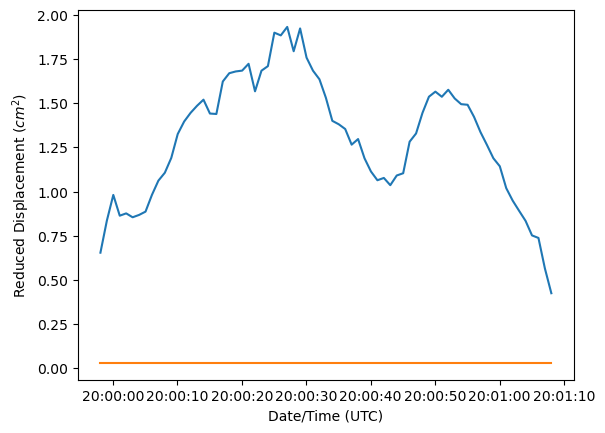

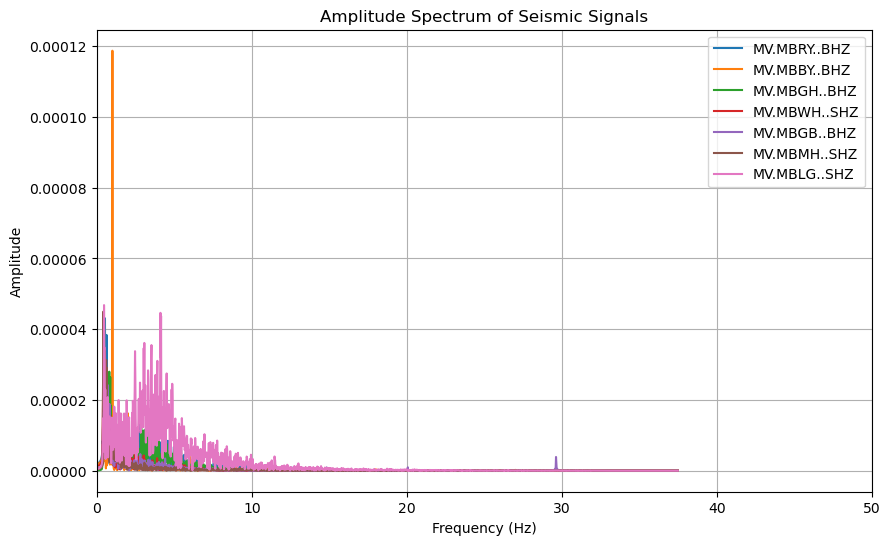

{'cft_peak_wmean': 4.362544254579812,
 'cft_peaks': [4.58800935031611,
               5.279834248549327,
               4.162445070461804,
               4.214897216292824,
               3.567535387278996],
 'cft_std_wmean': 0.797490614162712,
 'cft_stds': [0.8926827666795987,
              0.9077708758660166,
              0.8705251460434179,
              0.78360647238352,
              0.532867809841007],
 'coincidence_sum': 5.0,
 'duration': 38.34666669368744,
 'similarity': {},
 'stations': ['MBLG', 'MBWH', 'MBGB', 'MBRY', 'MBGH'],
 'time': UTCDateTime(2001, 3, 1, 20, 9, 8, 680000),
 'trace_ids': ['MV.MBLG..SHZ',
               'MV.MBWH..SHZ',
               'MV.MBGB..BHZ',
               'MV.MBRY..BHZ',
               'MV.MBGH..BHZ']}


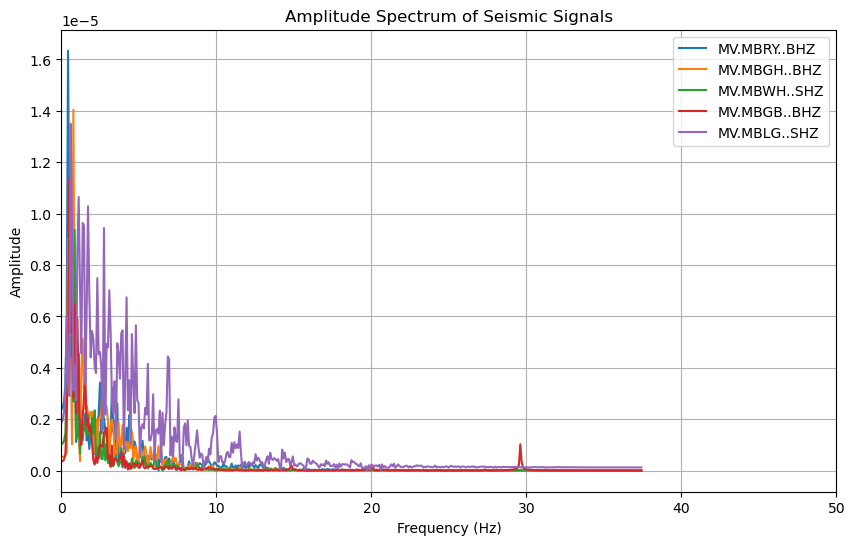

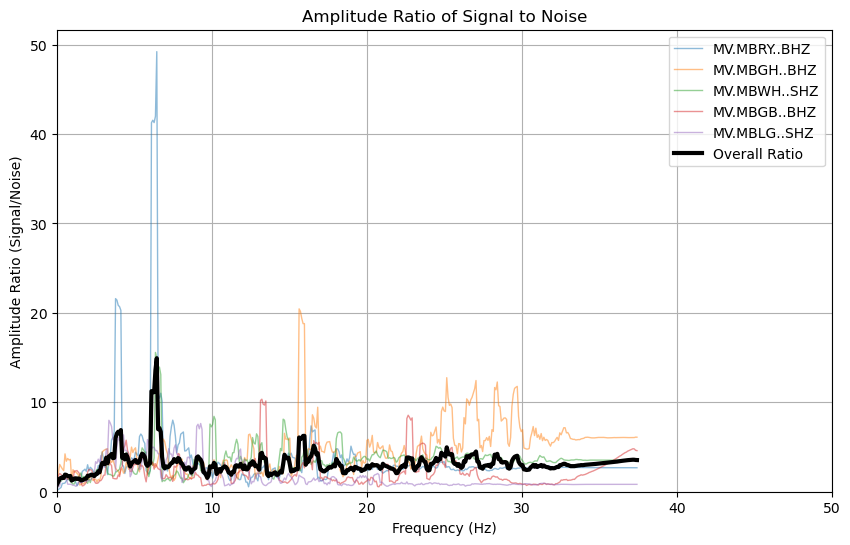

METRIC:  rms
9.230172897450703e-09
1.1118139976554754e-08
5.671980554231116e-09
5.127724517644179e-09
1.6725882321605287e-08
1.2497776041774403e-08
1.8495379765366202e-08
9.990452433526094e-09
8.439806763668048e-09
2.3670128815945704e-08
3.6279437446620572e-09
2.8428651062137198e-09
9.749988176091572e-10
1.3072599260849666e-09
8.412456610181777e-09
-62.271912577545635 -62.104855716288654 16.632908643211774 16.79290864321177
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-2008-57L.S200103; WAVfile: None

Sfile: 01-2012-08L.S200103; WAVfile: 2001-03-01-2012-08S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T20:12:08.040000Z - 2001-03-01T20:14:03.026667Z | 75.0 Hz, 8625 samples
MV.MBSS..SHZ | 2001-03-01T20:12:08.040000Z - 2001-03-01T20:14:03.026667Z | 75.0 Hz, 8625 samples
MV.MBBY..BHZ | 2001-03-01T20:12:08.040000Z - 2001-03-01T20:14:03.026667Z | 75.0 Hz, 8625 samples
MV.MBGH..BHZ | 2001-03-01T20:12:08.040000Z - 2001-03-01T20:14:03.026667Z | 75.0 

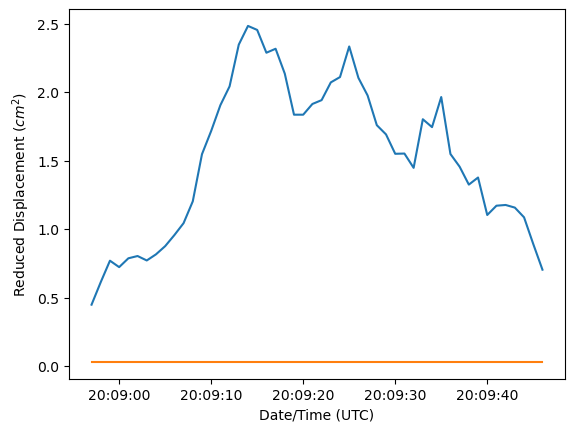

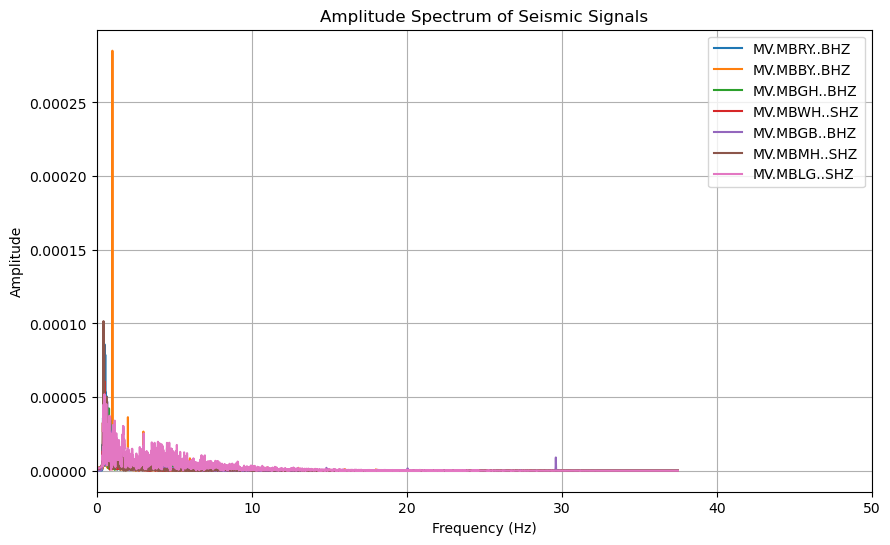

{'cft_peak_wmean': 4.642648854269386,
 'cft_peaks': [3.8337378644263294,
               4.997093342194937,
               5.681681939233157,
               3.9133100819710096,
               4.787421043521497],
 'cft_std_wmean': 0.7712334475541549,
 'cft_stds': [0.7281117036038111,
              0.7928012406871355,
              0.8847542329575837,
              0.6113723297476137,
              0.8391277307746301],
 'coincidence_sum': 5.0,
 'duration': 73.4266666173935,
 'similarity': {},
 'stations': ['MBWH', 'MBLG', 'MBRY', 'MBGB', 'MBGH'],
 'time': UTCDateTime(2001, 3, 1, 20, 12, 18, 40000),
 'trace_ids': ['MV.MBWH..SHZ',
               'MV.MBLG..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBGB..BHZ',
               'MV.MBGH..BHZ']}


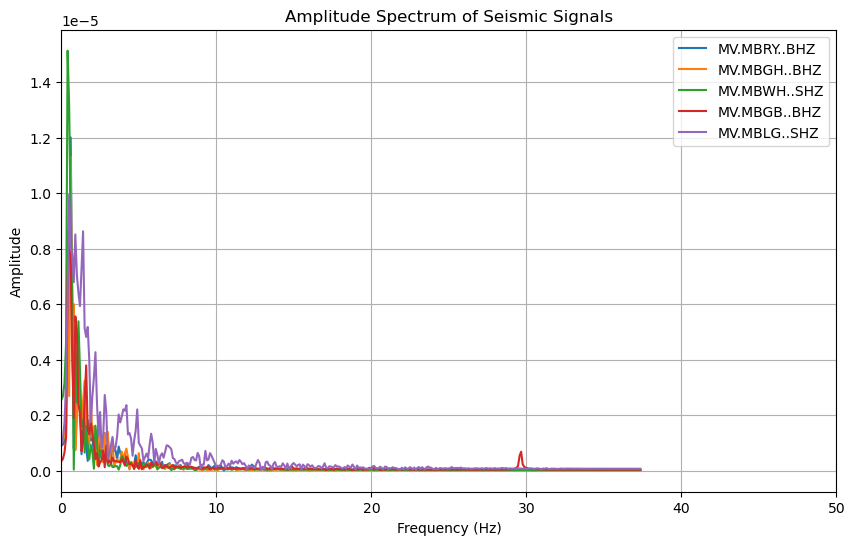

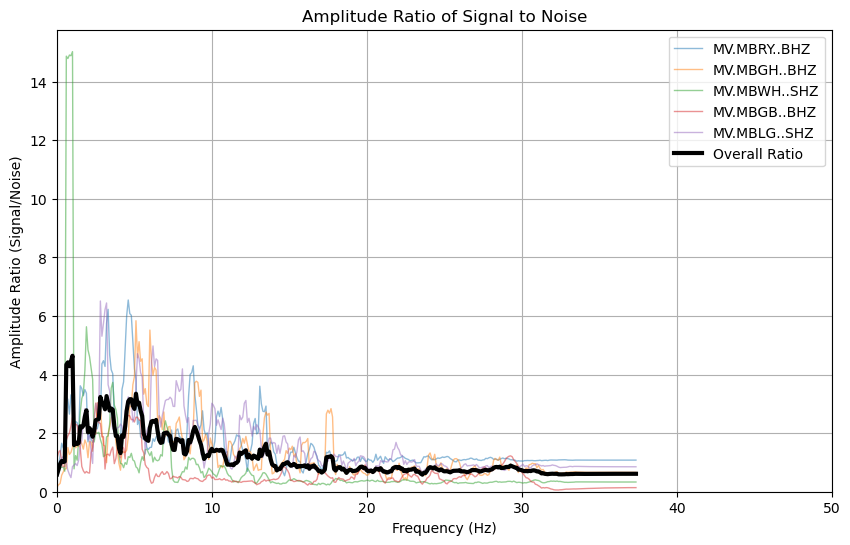

METRIC:  rms
4.483675292844975e-09
5.5962742021145465e-09
2.6116563142379436e-09
4.368342561861046e-09
7.380338574440037e-09
6.913388049153423e-09
7.647796848458131e-09
3.3377666164063e-09
7.705282395085676e-09
9.710649031922674e-09
1.1316619151324082e-09
1.9060953936808328e-09
3.09077526173275e-10
1.0991294305443918e-09
3.308019817417599e-09
-62.28307278905108 -62.11602379861733 16.6239154271526 16.783915427152596
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-2012-08L.S200103; WAVfile: None

Sfile: 01-2018-08L.S200103; WAVfile: 2001-03-01-2018-08S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T20:18:08.040000Z - 2001-03-01T20:20:02.026667Z | 75.0 Hz, 8550 samples
MV.MBSS..SHZ | 2001-03-01T20:18:08.040000Z - 2001-03-01T20:20:02.026667Z | 75.0 Hz, 8550 samples
MV.MBBY..BHZ | 2001-03-01T20:18:08.040000Z - 2001-03-01T20:20:02.026667Z | 75.0 Hz, 8550 samples
MV.MBGH..BHZ | 2001-03-01T20:18:08.040000Z - 2001-03-01T20:20:02.026667Z | 75.0 Hz, 8550 

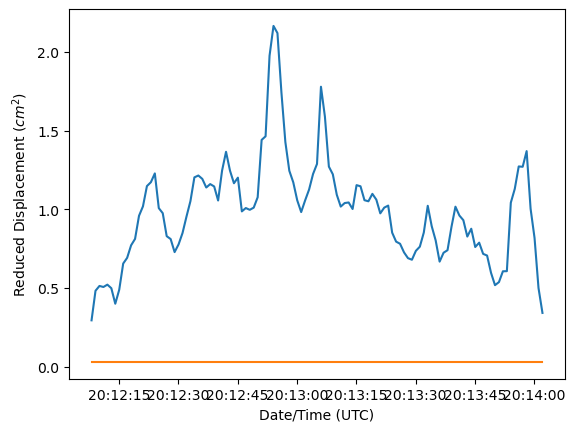

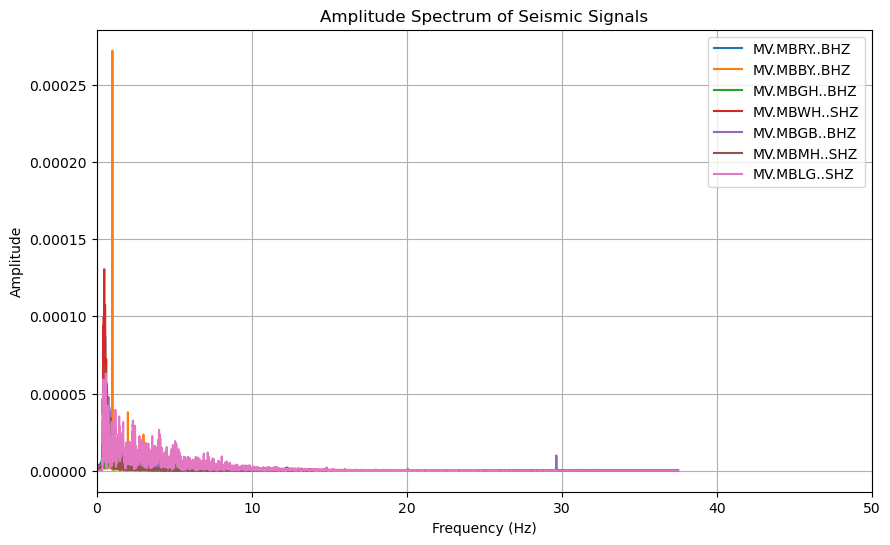

{'cft_peak_wmean': 5.073222881988096,
 'cft_peaks': [5.078359940646233,
               7.772395730479592,
               4.737653212970451,
               3.892308576375913,
               3.978310492016321,
               4.980309339440068],
 'cft_std_wmean': 0.8750947357107255,
 'cft_stds': [0.7166559776631138,
              1.2093595776759414,
              0.883567735070251,
              0.9445244152012453,
              0.6862798068081435,
              0.8101809018456573],
 'coincidence_sum': 6.0,
 'duration': 43.666666746139526,
 'similarity': {},
 'stations': ['MBRY', 'MBLG', 'MBWH', 'MBMH', 'MBGH', 'MBGB'],
 'time': UTCDateTime(2001, 3, 1, 20, 18, 18, 386667),
 'trace_ids': ['MV.MBRY..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBWH..SHZ',
               'MV.MBMH..SHZ',
               'MV.MBGH..BHZ',
               'MV.MBGB..BHZ']}


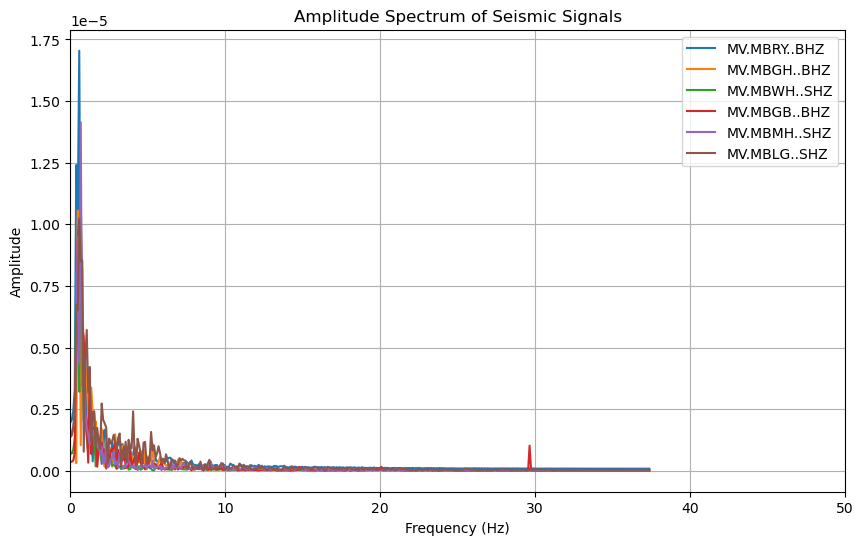

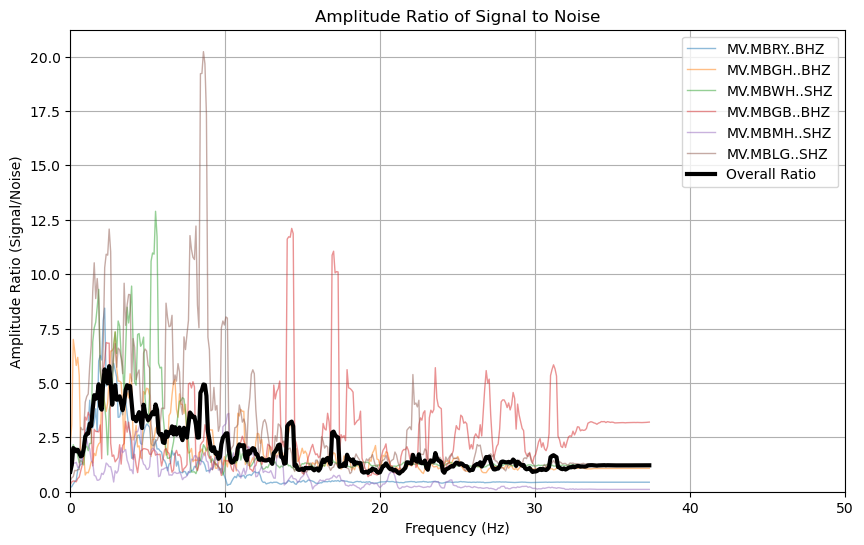

METRIC:  rms
6.03607774684991e-09
4.948659168067476e-09
5.508273523005764e-09
4.8893202368069816e-09
5.42959886902216e-09
7.1482978540470535e-09
7.109126331070505e-09
9.480952825978577e-09
8.247336798480993e-09
5.8013706772676755e-09
7.922739584615048e-09
1.2630143299946106e-08
1.4320864216395337e-09
1.3703653562937415e-09
3.3321505571568867e-10
9.171362643199858e-10
1.3214068625332635e-09
3.371289747751587e-09
-62.28003510719978 -62.1129719457866 16.640103216059114 16.80010321605911
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-2018-08L.S200103; WAVfile: None

Sfile: 01-2022-28L.S200103; WAVfile: 2001-03-01-2022-28S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T20:22:28.040000Z - 2001-03-01T20:23:41.026667Z | 75.0 Hz, 5475 samples
MV.MBSS..SHZ | 2001-03-01T20:22:28.040000Z - 2001-03-01T20:23:41.026667Z | 75.0 Hz, 5475 samples
MV.MBBY..BHZ | 2001-03-01T20:22:28.040000Z - 2001-03-01T20:23:41.026667Z | 75.0 Hz, 5475 samples
MV.MBGH..BHZ | 2001

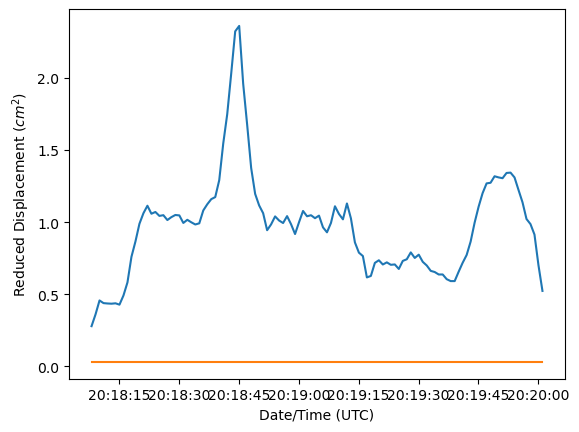

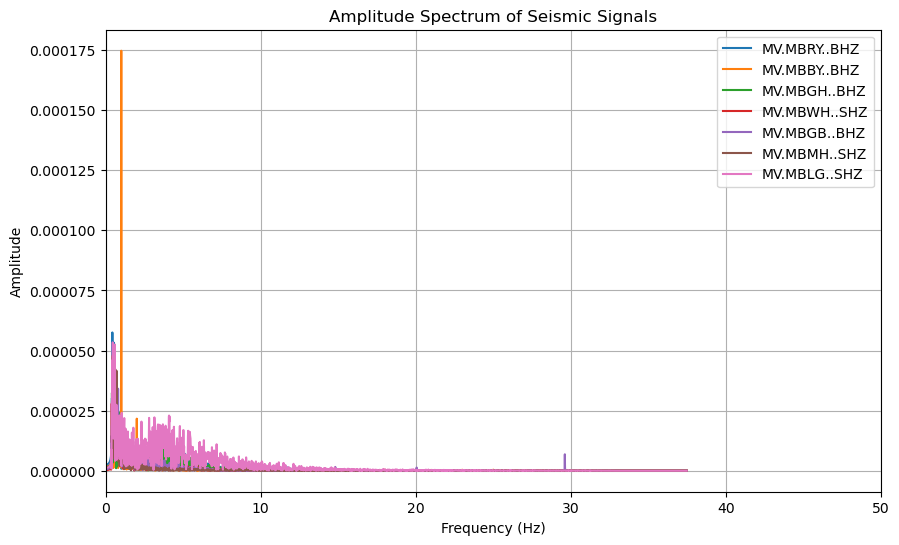

{'cft_peak_wmean': 4.0430237414220835,
 'cft_peaks': [4.968762926579088,
               3.5229792635053734,
               3.847258583921804,
               3.833094191682069],
 'cft_std_wmean': 0.6569790060144699,
 'cft_stds': [0.5789406126072667,
              0.5803901385222201,
              0.5760668614832062,
              0.8925184114451868],
 'coincidence_sum': 4.0,
 'duration': 55.573333382606506,
 'similarity': {},
 'stations': ['MBLG', 'MBGH', 'MBRY', 'MBMH'],
 'time': UTCDateTime(2001, 3, 1, 20, 22, 38, 40000),
 'trace_ids': ['MV.MBLG..SHZ', 'MV.MBGH..BHZ', 'MV.MBRY..BHZ', 'MV.MBMH..SHZ']}
Sfile: 01-2022-28L.S200103; WAVfile: None

Sfile: 01-2033-49L.S200103; WAVfile: 2001-03-01-2033-49S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T20:33:49.040000Z - 2001-03-01T20:35:06.026667Z | 75.0 Hz, 5775 samples
MV.MBSS..SHZ | 2001-03-01T20:33:49.040000Z - 2001-03-01T20:35:06.026667Z | 75.0 Hz, 5775 samples
MV.MBBY..BHZ | 2001-03-01T20:33:49.040000Z - 2001-03-01T20:35:06

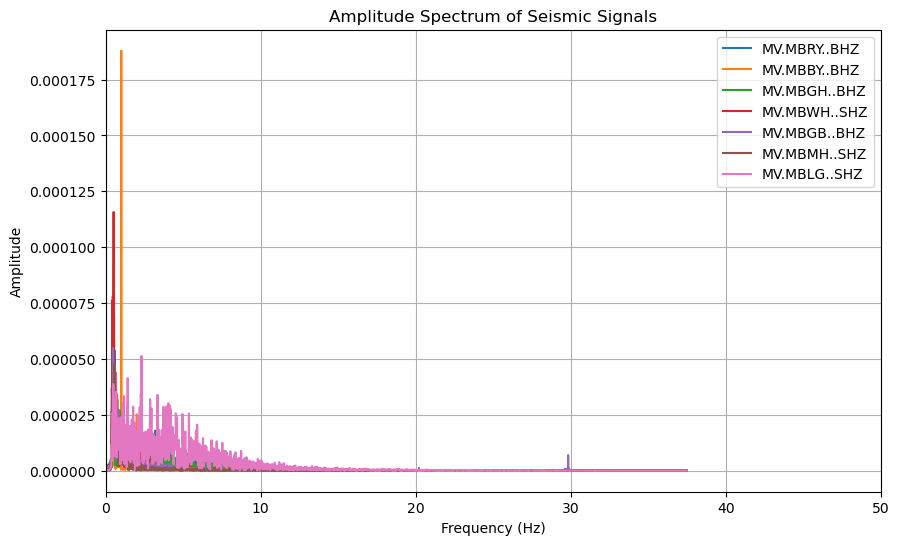

{'cft_peak_wmean': 4.96525982429257,
 'cft_peaks': [7.553666912991071,
               4.465434977911903,
               4.102554396344581,
               3.739383009922727],
 'cft_std_wmean': 0.967678586482074,
 'cft_stds': [1.1637837999918241,
              0.8510000636827639,
              1.155446582182759,
              0.7004839000709487],
 'coincidence_sum': 4.0,
 'duration': 54.61333346366882,
 'similarity': {},
 'stations': ['MBLG', 'MBWH', 'MBGB', 'MBMH'],
 'time': UTCDateTime(2001, 3, 1, 20, 33, 59, 40000),
 'trace_ids': ['MV.MBLG..SHZ', 'MV.MBWH..SHZ', 'MV.MBGB..BHZ', 'MV.MBMH..SHZ']}
Sfile: 01-2033-49L.S200103; WAVfile: None

Sfile: 01-2039-35L.S200103; WAVfile: 2001-03-01-2039-35S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T20:39:35.040000Z - 2001-03-01T20:41:18.026667Z | 75.0 Hz, 7725 samples
MV.MBSS..SHZ | 2001-03-01T20:39:35.040000Z - 2001-03-01T20:41:18.026667Z | 75.0 Hz, 7725 samples
MV.MBBY..BHZ | 2001-03-01T20:39:35.040000Z - 2001-03-01T20:41:18.02666

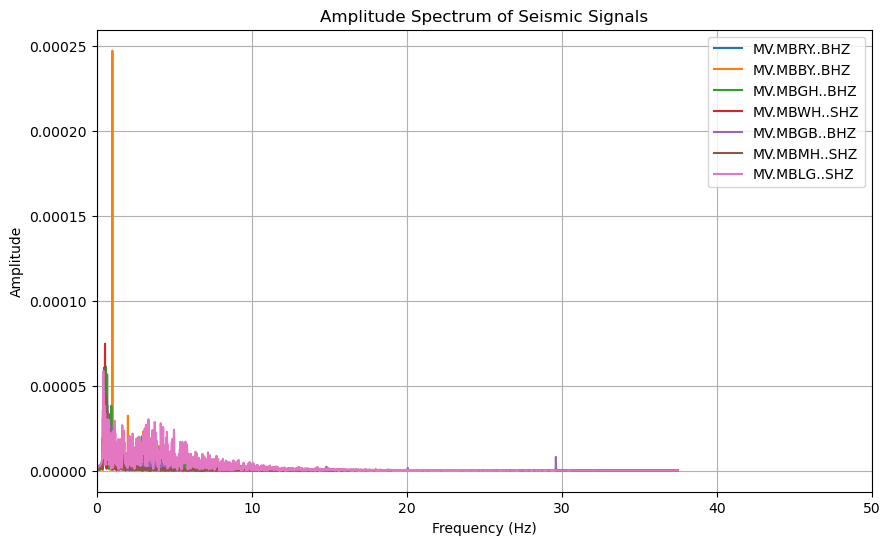

{'cft_peak_wmean': 4.261245542293925,
 'cft_peaks': [4.1817637908688265,
               4.655717613119023,
               4.727303842533435,
               3.879615665294168,
               4.124564255831789,
               3.9985080861163094],
 'cft_std_wmean': 0.9115583549750879,
 'cft_stds': [0.8104752195160916,
              1.3947345774200972,
              0.7473424763912896,
              0.571516771947534,
              0.781897849603123,
              1.163383234972391],
 'coincidence_sum': 6.0,
 'duration': 92.92000007629395,
 'similarity': {},
 'stations': ['MBWH', 'MBMH', 'MBLG', 'MBGH', 'MBGB', 'MBRY'],
 'time': UTCDateTime(2001, 3, 1, 20, 39, 45, 106667),
 'trace_ids': ['MV.MBWH..SHZ',
               'MV.MBMH..SHZ',
               'MV.MBLG..SHZ',
               'MV.MBGH..BHZ',
               'MV.MBGB..BHZ',
               'MV.MBRY..BHZ']}


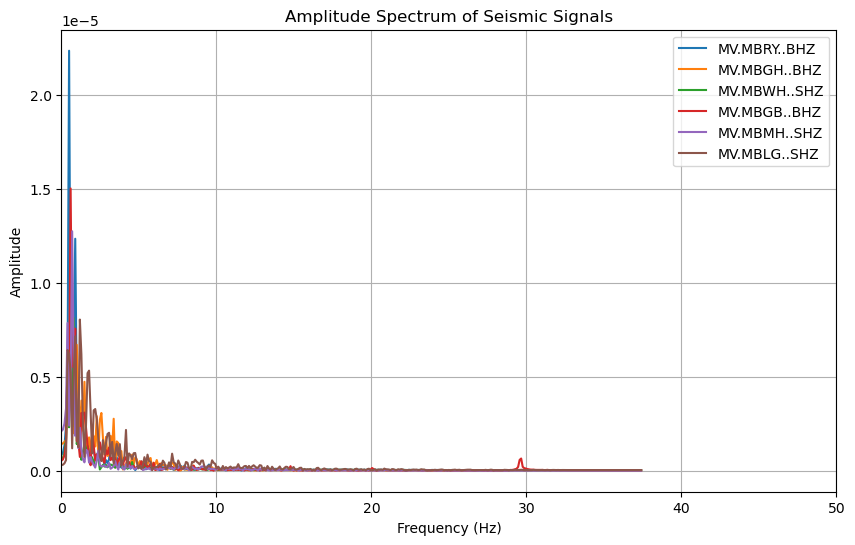

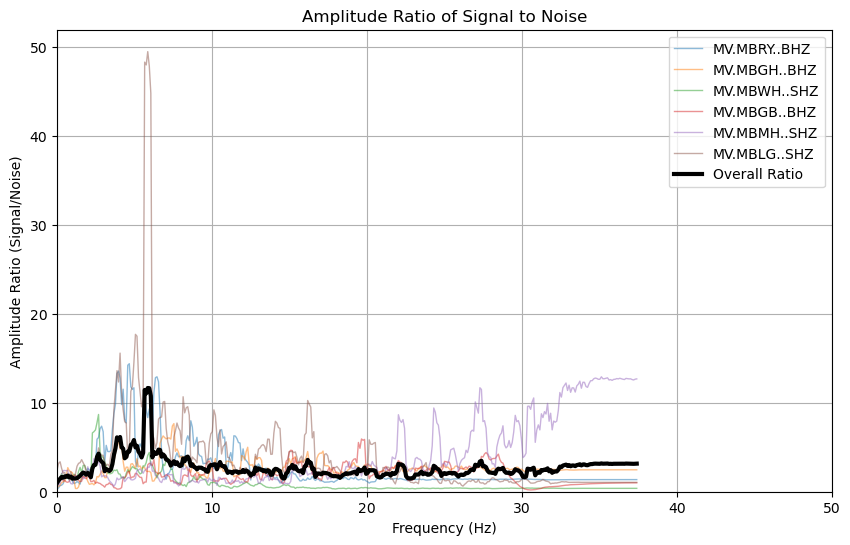

METRIC:  rms
5.4842574268585196e-09
5.7648929271687774e-09
3.75201164760482e-09
6.007199854400303e-09
4.439305714856049e-09
7.636721081799773e-09
6.202459464235573e-09
9.343729688524962e-09
5.7963918510416e-09
8.040119414391817e-09
5.9958146154078395e-09
1.1340995328456203e-08
1.0816049541245608e-09
2.1149011075627835e-09
3.6416003202330905e-10
1.385626935003975e-09
1.4115114115480713e-09
3.2247245698617114e-09
-62.27902254833167 -62.1119546597607 16.645499145694618 16.805499145694615
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-2039-35L.S200103; WAVfile: None

Sfile: 01-2133-07L.S200103; WAVfile: 2001-03-01-2133-07S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T21:33:07.040000Z - 2001-03-01T21:34:56.026667Z | 75.0 Hz, 8175 samples
MV.MBSS..SHZ | 2001-03-01T21:33:07.040000Z - 2001-03-01T21:34:56.026667Z | 75.0 Hz, 8175 samples
MV.MBBY..BHZ | 2001-03-01T21:33:07.040000Z - 2001-03-01T21:34:56.026667Z | 75.0 Hz, 8175 samples
MV.MBGH..BHZ | 200

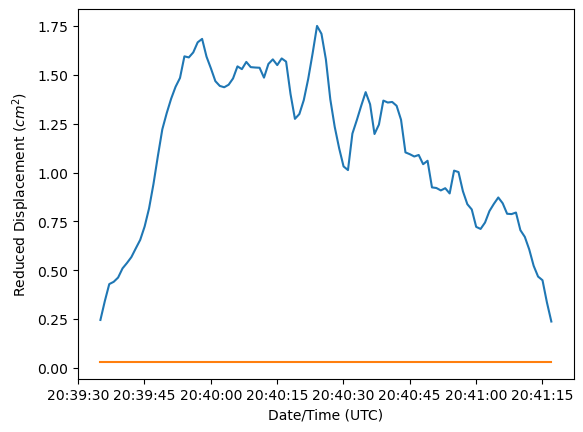

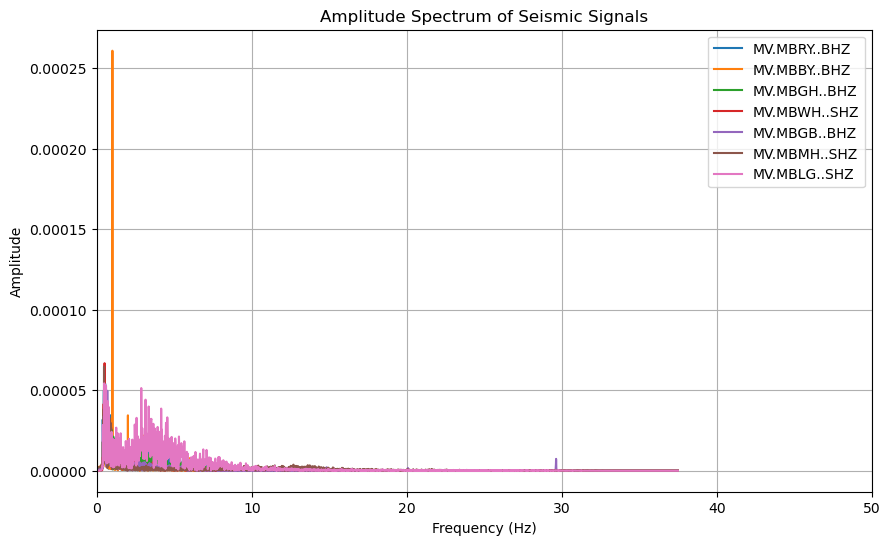

{'cft_peak_wmean': 4.272232712957237,
 'cft_peaks': [3.7719274067664195,
               4.7489578877878795,
               5.494308826818662,
               3.620219559262051,
               3.7257498841511727],
 'cft_std_wmean': 0.8167382222805607,
 'cft_stds': [0.8664189543754036,
              0.8988271859040884,
              1.040094251933483,
              0.5507020713900929,
              0.7276486477997359],
 'coincidence_sum': 5.0,
 'duration': 37.41333329677582,
 'similarity': {},
 'stations': ['MBMH', 'MBRY', 'MBLG', 'MBWH', 'MBGB'],
 'time': UTCDateTime(2001, 3, 1, 21, 33, 19, 493333),
 'trace_ids': ['MV.MBMH..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBWH..SHZ',
               'MV.MBGB..BHZ']}


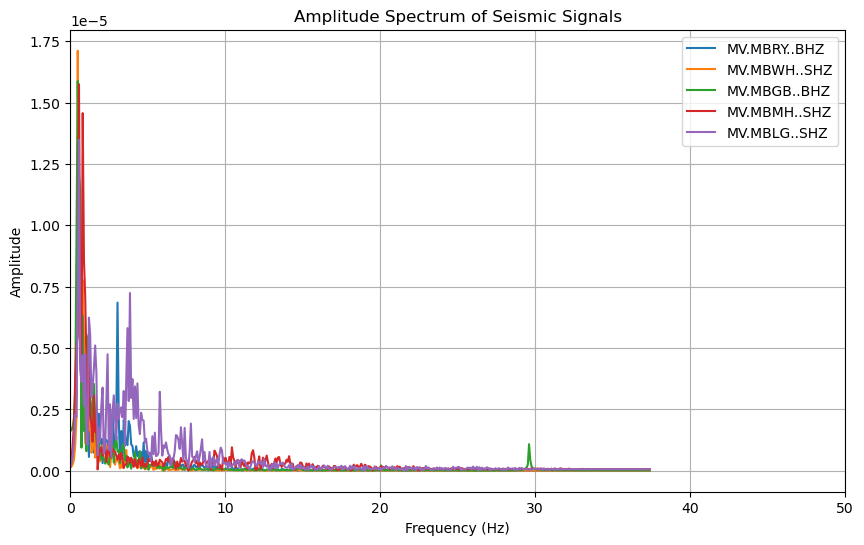

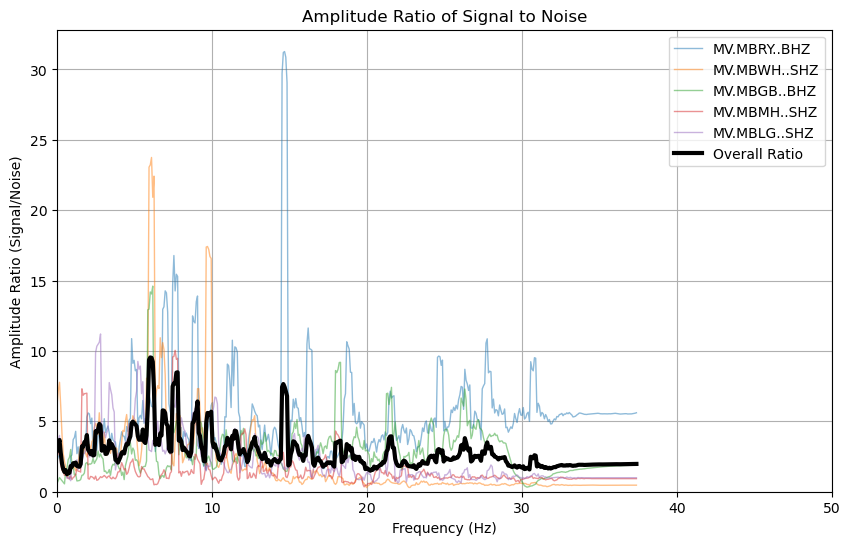

METRIC:  rms
3.6703703195440094e-09
4.30640859649365e-09
4.578010275424567e-09
5.325056936114244e-09
6.408394507399347e-09
7.687647150461734e-09
6.498051653527802e-09
7.441857601599094e-09
7.045967779255425e-09
1.2084907850287592e-08
6.412718725489911e-10
3.0445563252792446e-10
8.946951781206233e-10
2.728671084343904e-09
2.1146552449716645e-09
-62.276991127621216 -62.10992639068313 16.64190185927095 16.801901859270945
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-2133-07L.S200103; WAVfile: None

Sfile: 01-2135-26L.S200103; WAVfile: 2001-03-01-2135-26S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T21:35:26.040000Z - 2001-03-01T21:36:55.026667Z | 75.0 Hz, 6675 samples
MV.MBSS..SHZ | 2001-03-01T21:35:26.040000Z - 2001-03-01T21:36:55.026667Z | 75.0 Hz, 6675 samples
MV.MBBY..BHZ | 2001-03-01T21:35:26.040000Z - 2001-03-01T21:36:55.026667Z | 75.0 Hz, 6675 samples
MV.MBGH..BHZ | 2001-03-01T21:35:26.040000Z - 2001-03-01T21:36:55.026667Z | 75.0 Hz, 66

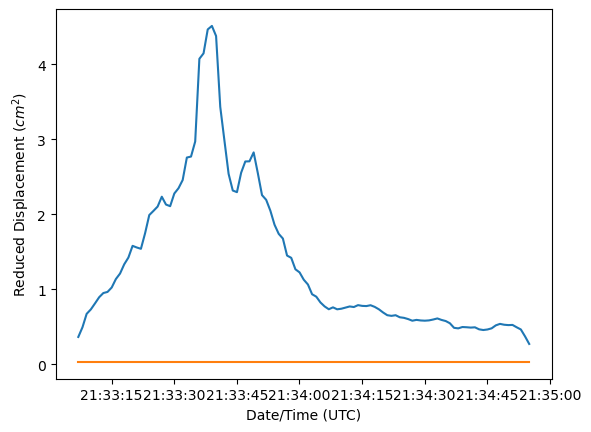

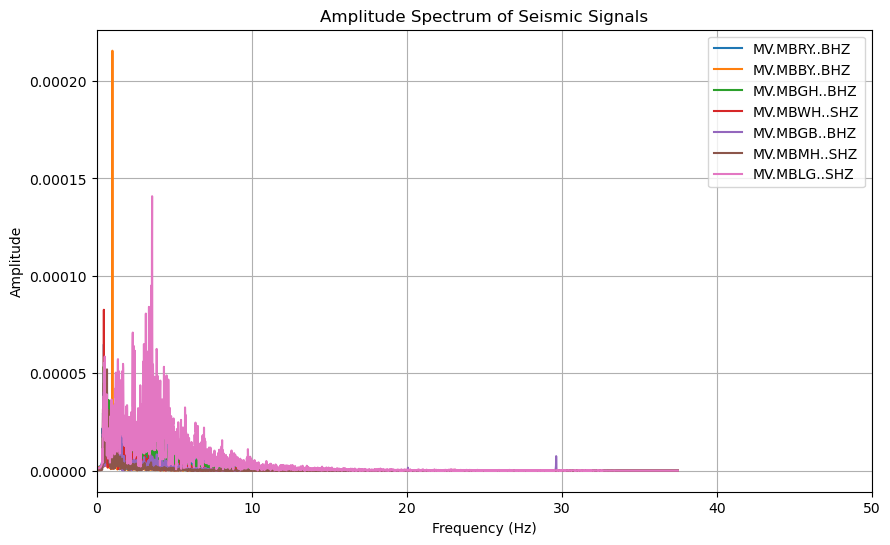

{'cft_peak_wmean': 5.9379179132025355,
 'cft_peaks': [4.705487252025283,
               6.479807845119489,
               8.433401891404388,
               6.187187410170889,
               4.247350195849096,
               5.574272884646064],
 'cft_std_wmean': 1.0361392829501863,
 'cft_stds': [0.8943166953955501,
              1.119587597751793,
              1.3981294846442855,
              0.9525825148762798,
              1.0540258533516014,
              0.7981935516816082],
 'coincidence_sum': 6.0,
 'duration': 62.72000002861023,
 'similarity': {},
 'stations': ['MBGB', 'MBWH', 'MBLG', 'MBRY', 'MBMH', 'MBGH'],
 'time': UTCDateTime(2001, 3, 1, 21, 35, 36, 40000),
 'trace_ids': ['MV.MBGB..BHZ',
               'MV.MBWH..SHZ',
               'MV.MBLG..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBMH..SHZ',
               'MV.MBGH..BHZ']}


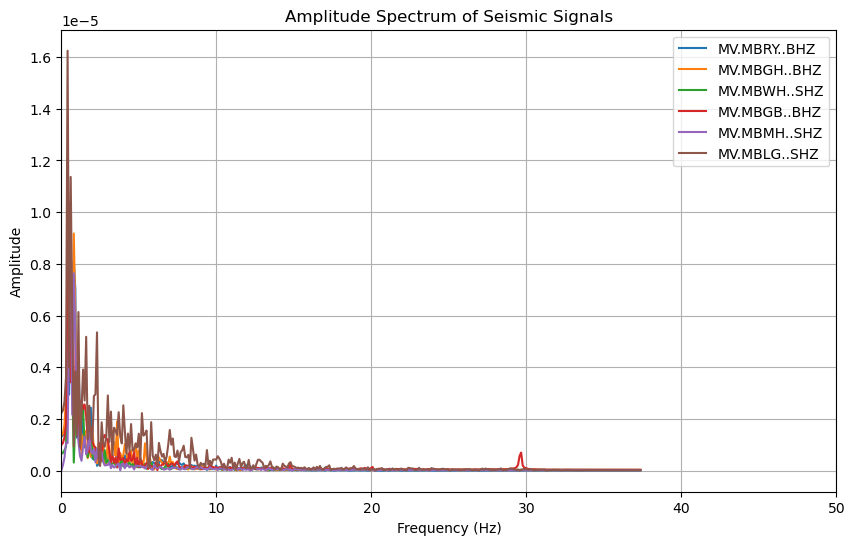

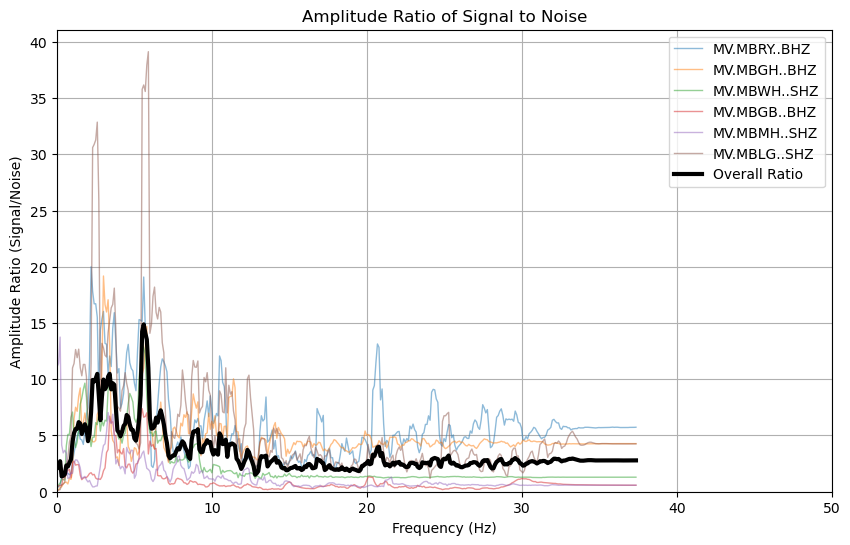

METRIC:  rms
3.6054500008260935e-09
6.141826899205592e-09
5.191943681367901e-09
5.421339499552069e-09
4.2119888318278764e-09
1.332293555155331e-08
4.464161714354972e-09
1.1322317796760093e-08
8.799838612742295e-09
6.631480759356785e-09
5.511253026892043e-09
2.10642250505386e-08
1.7841435707547541e-09
2.768717592633857e-09
5.252408457178762e-10
1.4610377750236192e-09
8.975041195076086e-10
8.00897551428492e-09
-62.28003195712168 -62.1129750958647 16.632908643211774 16.79290864321177
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-2135-26L.S200103; WAVfile: None

Sfile: 01-2142-13L.S200103; WAVfile: 2001-03-01-2142-13S.MVO___019

8 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-03-01T21:42:13.040000Z - 2001-03-01T21:43:27.026667Z | 75.0 Hz, 5550 samples
MV.MBSS..SHZ | 2001-03-01T21:42:13.040000Z - 2001-03-01T21:43:27.026667Z | 75.0 Hz, 5550 samples
MV.MBBY..BHZ | 2001-03-01T21:42:13.040000Z - 2001-03-01T21:43:27.026667Z | 75.0 Hz, 5550 samples
MV.MBGH..BHZ | 2001-03

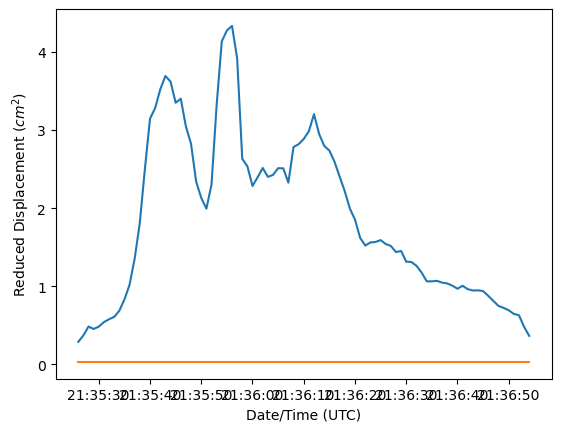

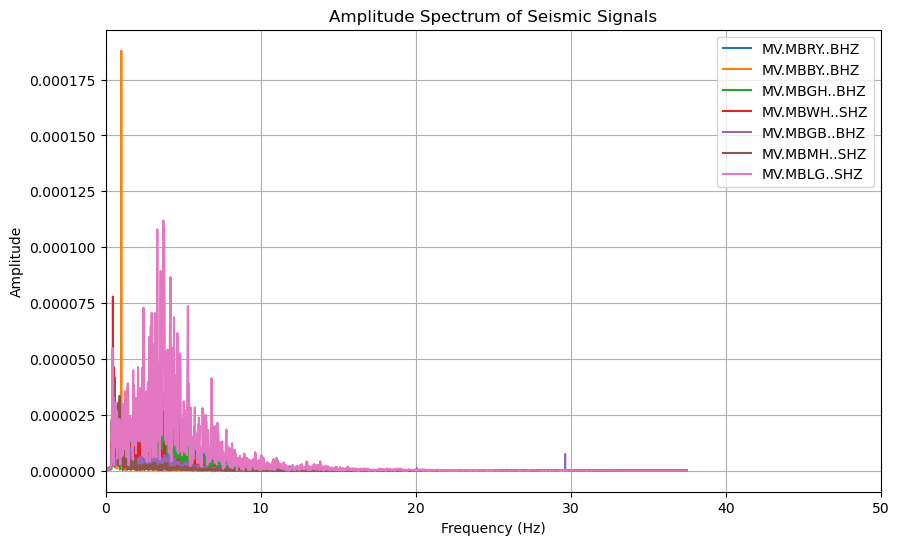

{'cft_peak_wmean': 5.88597865075944,
 'cft_peaks': [4.599674954920217,
               9.929391719997982,
               5.580176328533658,
               5.545609123051657,
               5.643979139516406,
               4.017040638536717],
 'cft_std_wmean': 1.004277784641033,
 'cft_stds': [0.7475647842553125,
              1.5241654255551904,
              0.8168973295013985,
              0.8097266414243364,
              1.268641603816613,
              0.8586709232933464],
 'coincidence_sum': 6.0,
 'duration': 60.639999985694885,
 'similarity': {},
 'stations': ['MBGH', 'MBLG', 'MBRY', 'MBWH', 'MBMH', 'MBGB'],
 'time': UTCDateTime(2001, 3, 1, 21, 42, 23, 120000),
 'trace_ids': ['MV.MBGH..BHZ',
               'MV.MBLG..SHZ',
               'MV.MBRY..BHZ',
               'MV.MBWH..SHZ',
               'MV.MBMH..SHZ',
               'MV.MBGB..BHZ']}


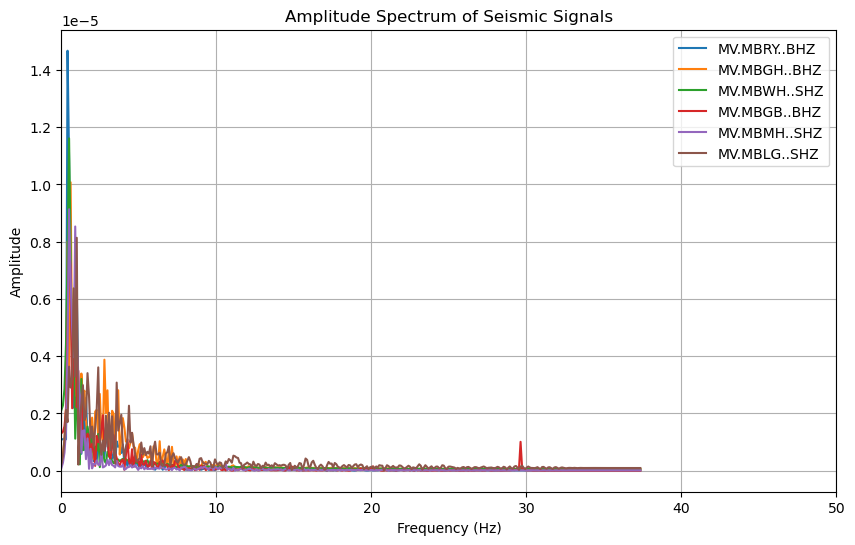

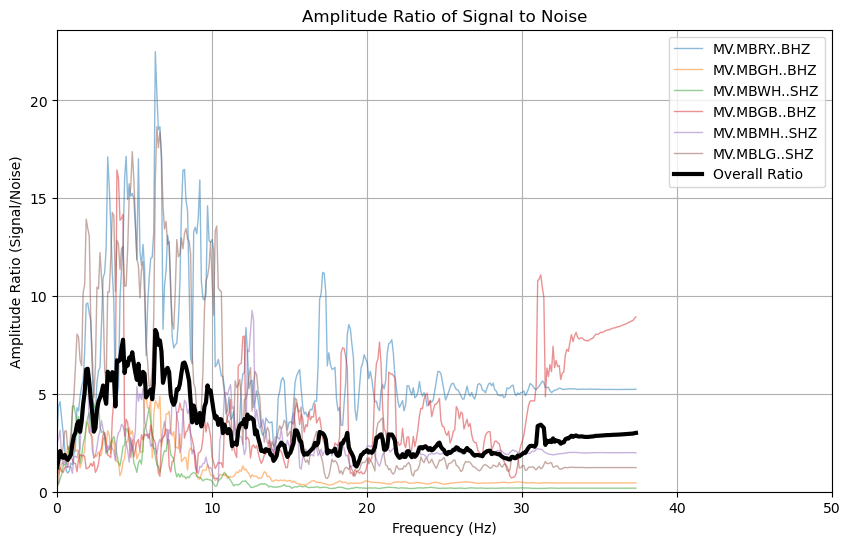

METRIC:  rms
6.071620191747214e-09
5.261036336758385e-09
3.3775574887033975e-09
4.915868292600254e-09
3.327454675459234e-09
1.134640148410645e-08
1.018520023143148e-08
6.57990590119435e-09
5.961019622741275e-09
7.073199001783808e-09
4.522874717485822e-09
1.960653721097104e-08
1.3978036061181212e-09
3.0711302600303495e-09
3.7108544167726054e-10
2.003263889934122e-09
7.841017509315206e-10
4.1614000760652e-09
-62.2688725359048 -62.10180622324746 16.643700502482783 16.80370050248278
Reading topo (earth relief) data from GMT website
ergrid downloaded
Sfile: 01-2142-13L.S200103; WAVfile: None



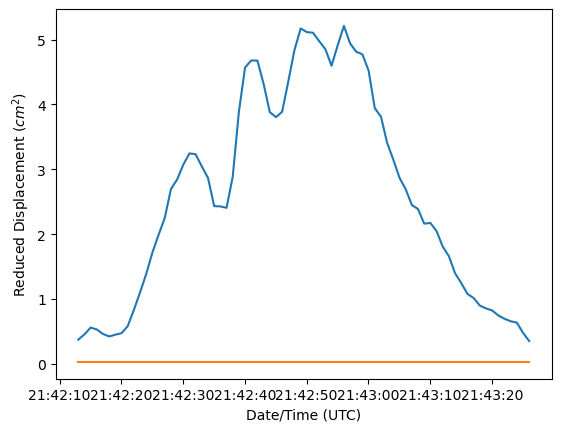

In [ ]:
#import matplotlib.pyplot as plt
def asl_event(st, raw_st, **kwargs):
    print(f"Received kwargs in asl_event: {kwargs}")
    if len(st) > 0 and isinstance(st, Stream):
        pass
    else:
        print(f"Empty stream for asl_event: {st}")
        return

    # Set default values for parameters (if not provided in **kwargs)
    Q = kwargs.get("Q", 23)  
    surfaceWaveSpeed_kms = kwargs.get("surfaceWaveSpeed_kms", 2.5)
    peakf = kwargs.get("peakf", 10.0)
    metric = kwargs.get("metric", 'VT')
    window_seconds = kwargs.get("window_seconds", 5)
    min_stations = kwargs.get("min_stations", 5)
    outdir =  os.path.join(kwargs.get("outdir", '.'), st[0].stats.starttime.strftime("%Y%m%dT%H%M%S")) 
    os.makedirs(outdir, exist_ok=True)

    print(f"Using Q={Q}, surfaceWaveSpeed_kms={surfaceWaveSpeed_kms}, peakf={peakf}")    
    if raw_st and isinstance(raw_st, Stream):
        rawstreampng = os.path.join(outdir, 'rawstream.png')
        raw_st.plot(equal_scale=False, outfile=rawstreampng);

    # plot pre-processed stream
    print(f'Stream for asl_event: {st}')
    if st and isinstance(st, Stream):
        streampng = os.path.join(outdir, 'stream.png')
        st.plot(equal_scale=False, outfile=streampng);
    
    # plot amplitude spectra
    plot_amplitude_spectra(st)    
    
    # detect
    best_trig = detect_network_event(st, minchans=None, threshon=3.5, threshoff=0.2, sta=0.5, lta=10.0, pad=0.0, best_only=True, freq=[2.0, 15.0])
    if not best_trig:
        return
    pprint(best_trig)
    if len(best_trig['trace_ids'])<min_stations:
        return
    
    # subset by detected stations
    detected_st = Stream(traces=[tr for tr in st if tr.id in best_trig['trace_ids']])

    # plot detected stream
    trig_time = best_trig['time'].matplotlib_date
    trig_end = (best_trig['time'] + best_trig['duration']).matplotlib_date
    fig = detected_st.plot(show=False)  # show=False prevents it from auto-displaying
    for ax in fig.axes:  # Stream.plot() returns multiple axes (one per trace)
        ax.axvline(trig_time, color='r', linestyle='--', label="Trigger Start")
        ax.axvline(trig_end, color='b', linestyle='--', label="Trigger End")
        ax.legend()
    #plt.savefig() # Display the plot    
    fig.savefig(os.path.join(outdir, 'detectedstream.png'), dpi=300, bbox_inches="tight")

    # noise spectra
    signal_st = detected_st.copy().trim(starttime=best_trig['time'], endtime=best_trig['time']+best_trig['duration'])
    noise_st = detected_st.copy().trim(endtime=best_trig['time'])
    plot_amplitude_spectra(noise_st) 
    plot_amplitude_ratios(signal_st, noise_st, log_scale=False, smooth_window=5)
    

    # compute DSAM data with 1-s time window
    dsamObj = DSAM(stream=detected_st, sampling_interval=1.0)
    #print(f'DSAM object for asl_event: {dsamObj}')

    # plot DSAM data
    if dsamObj and isinstance(dsamObj, DSAM):
        dsampng = os.path.join(outdir, 'DSAM.png')
        dsamObj.plot(metrics=metric, equal_scale=True, outfile=dsampng)

    '''
    # compute reduced displacement from DSAM data - assumes source at volcano
    DRSobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=True, Q=Q, wavespeed_kms=surfaceWaveSpeed_kms, peakf=peakf)

    # plot DRS data - we assume the frequency band of interest for PDCs is same as the VT band we use for band ratio calculations. I think this is 4-18 Hz. But we could give different banks to the DSAM calculation above
    DRSmaxrms = DRSobj.max(metric=metric)
    print(f'Maximum DRS assuming fixed source is: {DRSmaxrms}')

    # plot DRS data
    if DRSobj and isinstance(DRSobj, DRS):
        drspng = os.path.join(outdir, 'DRS.png')
        DRSobj.plot(metrics=metric, equal_scale=True, outfile=drspng)
    '''

    # same grid as before
    source = initial_source()
    gridobj = make_grid()

    # Create an ASL object with DSAM (displacement amplitude) data, inventory data, and a grid object. The inventory is used for station locations to compute distances
    aslobj = ASL(dsamObj, 'VT', inv, gridobj, window_seconds)

    # Compute grid distances
    aslobj.compute_grid_distances()

    # Compute amplitude corrections
    aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf = peakf)

    # Estimate source location for each time window of window_seconds
    source_pf = aslobj.fast_locate()
    #source_pf = aslobj.locate()
    #print(source_pf)

    # Plot the source location estimates
    # originally zoom_level=1, scale=0.2, number=10, equal_size=True
    aslobj.plot(source_pf, zoom_level=0, threshold_DR=0.03, \
                scale=0.2, join=True, number=0, \
                equal_size=False, add_labels=True, outfile=os.path.join(outdir, 'ASL.png')) 
                

read_seisandb_apply_custom_function_to_each_event(startdate, enddate, 
                                                SEISAN_DATA=SEISAN_DATA, 
                                                DB='MVOE_', 
                                                inv=inv, 
                                                post_process_function=asl_event, 
                                                #post_process_function=None, 
                                                verbose=True, 
                                                bool_clean=True, 
                                                plot=True, 
                                                valid_subclasses='re', 
                                                quality_threshold=1.0, 
                                                outputType='DISP', 
                                                freq=[0.5, 30.0],
                                                vertical_only=True, 
                                                # arguments for asl_event follow
                                                outdir='.',
                                                Q=23, 
                                                surfaceWaveSpeed_kms = 1.5,
                                                peakf = 8.0, 
                                                metric='rms',
                                                window_seconds=5, 
                                                min_stations=5
                                                )
                   